In [2]:
import sys
import os

this_path = os.getcwd()
path = '\\'.join(this_path.split('\\')[:-1])+'\\'
if path not in sys.path:
    sys.path.insert(0, path)
    print(path+" added to python path")
else:
    print(path+" already in python path")

%load_ext autoreload
%autoreload 2

C:\Users\mgutierrez\root\Projects\SDC\py\kaissandra\ added to python path


In [ ]:
# Train/Test RNN
import h5py
import numpy as np
import pickle
from inputs import Data, load_separators, _build_bin_output, build_IO_from_var, build_DTA_from_var
from RNN import modelRNN
from features import get_init_end_dates, get_group_name

dateTest = ([                                                       '2018.03.09',
                '2018.03.12','2018.03.13','2018.03.14','2018.03.15','2018.03.16',
                '2018.03.19','2018.03.20','2018.03.21','2018.03.22','2018.03.23',
                '2018.03.26','2018.03.27','2018.03.28','2018.03.29','2018.03.30',
                '2018.04.02','2018.04.03','2018.04.04','2018.04.05','2018.04.06',
                '2018.04.09','2018.04.10','2018.04.11','2018.04.12','2018.04.13',
                '2018.04.16','2018.04.17','2018.04.18','2018.04.19','2018.04.20',
                '2018.04.23','2018.04.24','2018.04.25','2018.04.26','2018.04.27',
                '2018.04.30','2018.05.01','2018.05.02','2018.05.03','2018.05.04',
                '2018.05.07','2018.05.08','2018.05.09','2018.05.10','2018.05.11',
                '2018.05.14','2018.05.15','2018.05.16','2018.05.17','2018.05.18',
                '2018.05.21','2018.05.22','2018.05.23','2018.05.24','2018.05.25',
                '2018.05.28','2018.05.29','2018.05.30','2018.05.31','2018.06.01',
                '2018.06.04','2018.06.05','2018.06.06','2018.06.07','2018.06.08',
                '2018.06.11','2018.06.12','2018.06.13','2018.06.14','2018.06.15',
                '2018.06.18','2018.06.19','2018.06.20','2018.06.21','2018.06.22',
                '2018.06.25','2018.06.26','2018.06.27','2018.06.28','2018.06.29',
                '2018.07.02','2018.07.03','2018.07.04','2018.07.05','2018.07.06',
                '2018.07.09','2018.07.10','2018.07.11','2018.07.12','2018.07.13',
                '2018.07.30','2018.07.31','2018.08.01','2018.08.02','2018.08.03',
                '2018.08.06','2018.08.07','2018.08.08','2018.08.09','2018.08.10']+
               ['2018.08.13','2018.08.14','2018.08.15','2018.08.16','2018.08.17',
                '2018.08.20','2018.08.21','2018.08.22','2018.08.23','2018.08.24',
                '2018.08.27','2018.08.28','2018.08.29','2018.08.30','2018.08.31',
                '2018.09.03','2018.09.04','2018.09.05','2018.09.06','2018.09.07',
                '2018.09.10','2018.09.11','2018.09.12','2018.09.13','2018.09.14',
                '2018.09.17','2018.09.18','2018.09.19','2018.09.20','2018.09.21',
                '2018.09.24','2018.09.25','2018.09.26','2018.09.27']+['2018.09.28',
                '2018.10.01','2018.10.02','2018.10.03','2018.10.04','2018.10.05',
                '2018.10.08','2018.10.09','2018.10.10','2018.10.11','2018.10.12',
                '2018.10.15','2018.10.16','2018.10.17','2018.10.18','2018.10.19',
                '2018.10.22','2018.10.23','2018.10.24','2018.10.25','2018.10.26',
                '2018.10.29','2018.10.30','2018.10.31','2018.11.01','2018.11.02',
                '2018.11.05','2018.11.06','2018.11.07','2018.11.08','2018.11.09'])

data=Data(movingWindow=100,
          nEventsPerStat=1000,
          lB=1300, 
          dateTest=dateTest,
          assets=[1,2,3,4,7,8,10,11,12,13,14,15,16,17,19,27,28,29,30,31,32],
          channels=[0],
          max_var=10,
          feature_keys_manual=[],
          feature_keys_tsfresh=[],#[i for i in range(37,48)]+[49,50]+[i for i in range(52,68)],
          var_feat_keys=[i for i in range(68,93)])

model=modelRNN(data,
               size_hidden_layer=100,
               L=3,
               size_output_layer=5,
               keep_prob_dropout=1,
               miniBatchSize=32,
               outputGain=.6,
               commonY=3,
               lR0=0.0001,
               num_epochs=20)

tOt = 'tr' # tr->train te->test
if tOt == 'tr':
    calculate_roi = False
else:
    calculate_roi = True
if_build_IO = False
from_stats_file = False

IDweights = '000400'
IDresults = '100400'
IO_results_name = IDresults
hdf5_directory = 'D:/SDC/py/HDF5/'
feats_var_directory = hdf5_directory+'feats_var/'
IO_directory = '../RNN/IO/'
if tOt=='tr':
    filename_IO = IO_directory+'IO_'+IDweights+'.hdf5'
else:
    filename_IO = IO_directory+'IO_'+IO_results_name+'.hdf5'
separators_directory = hdf5_directory+'separators/'

# if IO structures have to be built 
if if_build_IO:
    # init dictionary containing IO structures
    IO = {}
    # open IO file for writting
    f_IO = h5py.File(filename_IO,'w')
    # init IO data sets
    X = f_IO.create_dataset('X',
                            (0, model.seq_len, model.nFeatures), 
                            maxshape=(None,model.seq_len, model.nFeatures), 
                            dtype=float)
    Y = f_IO.create_dataset('Y',
                            (0,model.seq_len,model.commonY+model.size_output_layer),
                            maxshape=(None,model.seq_len,model.commonY+
                            model.size_output_layer),
                            dtype=float)
    if calculate_roi:
        D = f_IO.create_dataset('D', (0,2),
                                    maxshape=(None,2),dtype='S19')
        B = f_IO.create_dataset('B', (0,2),
                                    maxshape=(None,2),dtype=float)
        A = f_IO.create_dataset('A', (0,2),
                                    maxshape=(None,2),dtype=float)
        IO['D'] = D
        IO['B'] = B
        IO['A'] = A
    # attributes to track asset-IO belonging
    ass_IO_ass = np.zeros((len(data.assets))).astype(int)
    # structure that tracks the number of samples per level
    totalSampsPerLevel = np.zeros((model.size_output_layer))
    # save IO structures in dictionary
    IO['X'] = X
    IO['Y'] = Y
    IO['pointer'] = 0
    
for ass_idx, ass in enumerate(data.assets):
    thisAsset = data.AllAssets[str(ass)]
    print(str(ass)+" "+thisAsset)
    #thisAsset = 'EURUSD'
    # load separators
    separators = load_separators(data, 
                                 thisAsset, 
                                 separators_directory, 
                                 tOt='tr', 
                                 from_txt=1)
    aloc = 2**20
    # index asset
    #ass_idx = 0

    filename_features = (feats_var_directory+thisAsset+'_feats_var_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_features = h5py.File(filename_features,'r')
    filename_returns = (feats_var_directory+thisAsset+'_rets_var_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_returns = h5py.File(filename_returns,'r')
    filename_symbols = (feats_var_directory+thisAsset+'_symbols_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_symbols = h5py.File(filename_symbols,'r')
    filename_stats = (feats_var_directory+thisAsset+'_stats_mW'+str(data.movingWindow)+'_nE'+
                                    str(data.nEventsPerStat)+'.p')
    # init or load total stats
    if not from_stats_file:
        stats = {}
        # load stats in
        stats["means_in"] = file_features[thisAsset].attrs.get("means_in")
        stats["stds_in"] = file_features[thisAsset].attrs.get("stds_in")
        stats["m_in"] = file_features[thisAsset].attrs.get("m_in")
        # load stats out
        stats["means_out"] = file_returns[thisAsset].attrs.get("means_out")
        stats["stds_out"] = file_returns[thisAsset].attrs.get("stds_out")
        stats["m_out"] = file_returns[thisAsset].attrs.get("m_out")
    elif from_stats_file:
        stats = pickle.load( open( filename_stats, "rb" ))
    print(stats)

    nExS = data.nEventsPerStat
    mW = data.movingWindow
    if if_build_IO:
        for s in range(0,len(separators)-1,2):#
            print("\ts {0:d} of {1:d}".format(int(s/2),int(len(separators)/2-1))+
                  ". From "+separators.DateTime.iloc[s]+" to "+
                  separators.DateTime.iloc[s+1])

            # number of events within this separator chunk
            nE = separators.index[s+1]-separators.index[s]+1
            # get first day after separator
            day_s = separators.DateTime.iloc[s][0:10]
            # check if number of events is not enough to build two features and one return
            if nE-nExS>=2*nExS:
                if (tOt == 'tr' and (day_s not in data.dateTest and day_s<=data.dateTest[-1])) or \
                    (tOt == 'te' and (day_s in data.dateTest and day_s<=data.dateTest[-1])):
                    # init and end dates
                    init_date, end_date = get_init_end_dates(separators, s)
                    #print("init_date")
                    #print(init_date)
                    #print("end_date")
                    #print(end_date)
                    # get group name
                    group_name = get_group_name(thisAsset, init_date, end_date)
                    #print("group_name")
                    #print(group_name)
                    # load features
                    if group_name in file_features:
                        features = file_features[group_name]["features"]
                    else:
                        raise ValueError(group_name+" not in "+filename_features)
                    #print("features")
                    #print(features)
                    # load returns
                    if group_name in file_returns:
                        returns = file_returns[group_name]["returns"]
                    else:
                        raise ValueError(group_name+" not in "+filename_features)
                    #print(returns)
                    # load Symbols if calculate_roi is true
                    #TODO: Implement Symbol loading for test
                    if calculate_roi:
                        DT = file_symbols[group_name]["DT"]
                        B = file_symbols[group_name]["B"]
                        A = file_symbols[group_name]["A"]
                        # build dict w. symbols
                        symbols = {'DT':DT,
                                  'B':B,
                                  'A':A}
                    else:
                        symbols = {}
                    # build IO
                    IO, totalSampsPerLevel = build_IO_from_var_notebook(data, model, stats, IO, totalSampsPerLevel, 
                                                                        features, returns, symbols, calculate_roi)
                    print(totalSampsPerLevel)
                else:
                    print("\tNot in the set. Skipped.")

            else:
                print("\ts {0:d} of {1:d}. Not enough entries. Skipped.".format(
                    int(s/2),int(len(separators)/2-1)))
        # end of for s in range(0,len(separators)-1,2):
    if if_build_IO:
        ass_IO_ass[ass_idx] = IO['pointer']
        #print("\tTime for "+thisAsset+":"+str(np.floor(time.time()-tic))+"s"+
        #          ". Total time:"+str(np.floor(time.time()-ticTotal))+"s")
# end of for ass_idx, ass in enumerate(data.assets):
if if_build_IO:
    print("Samples to RNN: "+str(max(ass_IO_ass))+".\nPercent per level:"+
            str(totalSampsPerLevel/max(ass_IO_ass)))
    f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
    
    
    if calculate_roi:
        print("Building DTA...")
        DTA = build_DTA_from_var(data, IO['D'], IO['B'], IO['A'], ass_IO_ass)
        pickle.dump( DTA, open( "../RNN/IO/DTA"+"_"+IO_results_name+".p", "wb" ))
        f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
        
    f_IO.close()
else:
    if calculate_roi:
        DTA = pickle.load( open( "../RNN/IO/DTA"+"_"+IO_results_name+".p", "rb" ))
    # get ass_IO_ass from disk
    f_IO = h5py.File(filename_IO,'r')
    ass_IO_ass = f_IO.attrs.get("ass_IO_ass")
    f_IO.close()
m_t = max(ass_IO_ass)
print("DONE")

In [8]:
m_t

733966

In [ ]:
# Train
import tensorflow as tf
# reset graph
alloc = 2**20
tf.reset_default_graph()
# start session
with tf.Session() as sess:    
    model.train(sess, int(np.ceil(m_t/aloc)), ID=IDweights, IDIO=IDweights, 
                data_format='hdf5', filename_IO=filename_IO, aloc=alloc)

In [ ]:
# Test
import tensorflow as tf

alloc = 200000
save_journal = False
startFrom = -1
endAt = -1
# reset graph
tf.reset_default_graph()
# start session
with tf.Session() as sess:
    # run test RNN
    print("IDresults: "+IDresults)
    # TEMP: GRE calculation not implemented in test2 yet. Use old test
    if save_journal:
        model.test(sess, data, IDresults, IDweights, 
                    alloc, 'test', startFrom=startFrom,
                    IDIO=IO_results_name, data_format='hdf5', DTA=DTA, 
                    save_journal=save_journal, endAt=endAt)
    else:
        model.test2(sess, data, IDresults, IDweights, 
                    alloc, 'test', startFrom=startFrom,
                    IDIO=IO_results_name, data_format='hdf5', DTA=DTA, 
                    save_journal=save_journal, endAt=endAt, from_var=True)
print("DONE")

In [1]:
# Function Build IO from var
def build_IO_from_var_notebook(data, model, stats, IO, totalSampsPerLevel, features, returns, symbols, calculate_roi):
    # total number of possible channels
    nExS = data.nEventsPerStat
    mW = data.movingWindow
    nChannels = int(nExS/mW)
    # sequence length
    seq_len = model.seq_len#int((data.lB-data.nEventsPerStat)/data.movingWindow)
    # samples allocation per batch
    aloc = 2**20
    # extract means and stats
    means_in = stats['means_in']
    stds_in = stats['stds_in']
    #m_in = stats['m_in']
    stds_out = stats['stds_out']
    #m_out = stats['m_out']
    #print("m_in")
    #print(m_in)
    #print("m_out")
    #print(m_out)
    # add dateTimes, bids and asks if are included in file
    if calculate_roi:
        dts = symbols['DT']
        bids = symbols['B']
        asks = symbols['A']

        D = IO['D']
        B = IO['B']
        A = IO['A']

    # extract IO structures
    X = IO['X']
    Y = IO['Y']
    #I = IO['I']
    pointer = IO['pointer']

    feats_var_normed = np.minimum(np.maximum((features-means_in)/\
                         stds_in,-data.max_var),data.max_var)
    # get some scalars
    nSamps = feats_var_normed.shape[0]
    print("features.shape")
    print(features.shape)
    print("nSamps")
    print(nSamps)
    samp_remaining = nSamps-2*nChannels-seq_len+1
    print("samp_remaining")
    print(samp_remaining)
    print("returns.shape")
    print(returns.shape)
    chunks = int(np.ceil(samp_remaining/aloc))
    # init counter of samps processed
    offset = 0
    # loop over chunks
    for i in range(chunks):
        # this batch length
        batch = np.min([samp_remaining, aloc])
        # create support numpy vectors to speed up iterations
        v_support = feats_var_normed[offset:offset+batch+seq_len, :]
        # get init and end indexes for returns
        init_idx_rets = nChannels+offset+seq_len-1
        print("init_idx_rets")
        print(init_idx_rets)
        end_idx_rets = nChannels+offset+batch+seq_len-1#+2*seq_len-1
        print("end_idx_rets")
        print(end_idx_rets)
        r_support = returns[init_idx_rets:end_idx_rets, data.lookAheadIndex]
        print("r_support.shape")
        print(r_support.shape)
        assert(r_support.shape[0]==end_idx_rets-init_idx_rets)
        # we only take here the entry time index, and later at DTA building the 
        # exit time index is derived from the entry time and the number of events to
        # look ahead
        if calculate_roi:
            dt_support = dts[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
            b_support = bids[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
            a_support = asks[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        # update remaining samps to proceed
        samp_remaining = samp_remaining-batch
        # init formatted input and output
        X_i = np.zeros((batch, seq_len, features.shape[1]))
        # real-valued output
        O_i = np.zeros((batch, seq_len, 1))    
        if calculate_roi:
            # last dimension is to incorporate in and out symbols
            D_i = np.chararray((batch, 2),itemsize=19)
            B_i = np.zeros((batch, 2))
            A_i = np.zeros((batch, 2))

        for nI in range(batch):
            # get input
            v_s_s = v_support[nI:nI+seq_len, :]
            X_i[nI,:,:] = v_s_s[::-1,:]#v_support[nI:nI+seq_len, :]            
            # due to substraction of features for variation, output gets the 
            # feature one entry later
            O_i[nI,:,0] = r_support[nI]
            if calculate_roi:
                D_i[nI,:] = dt_support[nI,:]
                B_i[nI,:] = b_support[nI,:]
                A_i[nI,:] = a_support[nI,:]

        # normalize output
        O_i = O_i/stds_out[data.lookAheadIndex]
        # update counters
        offset = offset+batch
        # get decimal and binary outputs
        Y_i, y_dec = _build_bin_output(model, O_i, batch)
        # get samples per level
        for l in range(model.size_output_layer):
            totalSampsPerLevel[l] = totalSampsPerLevel[l]+np.sum(y_dec[:,-1,0]==l)
        # resize IO structures
        X.resize((pointer+batch, seq_len,features.shape[1]))
        Y.resize((pointer+batch, seq_len,model.commonY+model.size_output_layer))
        # update IO structures
        X[pointer:pointer+batch,:,:] = X_i
        Y[pointer:pointer+batch,:,:] = Y_i
        if calculate_roi:
            # resize
            D.resize((pointer+batch, 2))
            B.resize((pointer+batch, 2))
            A.resize((pointer+batch, 2))
            # update
            D[pointer:pointer+batch,:] = D_i
            B[pointer:pointer+batch,:] = B_i
            A[pointer:pointer+batch,:] = A_i
    #        save_as_matfile('X_h_n_'+str(int(s/2)),'X_h_n'+str(int(s/2)),X_i)
    #        save_as_matfile('O_h_n_'+str(int(s/2)),'O_h_n'+str(int(s/2)),O_i)

        # uodate pointer
        pointer += batch
    # end of for i in range(chunks):
    # update dictionary
    IO['X'] = X
    IO['Y'] = Y
    IO['pointer'] = pointer
    if calculate_roi:
        IO['D'] = D
        IO['B'] = B
        IO['A'] = A
    
    return IO, totalSampsPerLevel
    

In [ ]:
# Snippet Build IO from var

# total number of possible channels
nChannels = int(nExS/mW)
# sequence length
seq_len = model.seq_len#int((data.lB-data.nEventsPerStat)/data.movingWindow)
# samples allocation per batch
aloc = 2**20
# extract means and stats
means_in = stats['means_in']
stds_in = stats['stds_in']
m_in = stats['m_in']
stds_out = stats['stds_out']
m_out = stats['m_out']
#print("m_in")
#print(m_in)
#print("m_out")
#print(m_out)
# add dateTimes, bids and asks if are included in file
all_info = 0
if calculate_roi:
    all_info = 1
    dts = symbols['DT']
    bids = symbols['B']
    asks = symbols['A']
        
    D = IO['D']
    B = IO['B']
    A = IO['A']

# extract IO structures
X = IO['X']
Y = IO['Y']
#I = IO['I']
pointer = IO['pointer']

feats_var_normed = np.minimum(np.maximum((features-means_in)/\
                     stds_in,-data.max_var),data.max_var)
# get some scalars
nSamps = feats_var_normed.shape[0]
samp_remaining = nSamps-nChannels-seq_len-1
print("samp_remaining")
print(samp_remaining)
chunks = int(np.ceil(samp_remaining/aloc))
# init counter of samps processed
offset = 0
# loop over chunks
for i in range(chunks):
    # this batch length
    batch = np.min([samp_remaining,aloc])
    print("batch")
    print(batch)
    # create support numpy vectors to speed up iterations
    v_support = feats_var_normed[offset:offset+batch+seq_len, :]
    # get init and end indexes for returns
    init_idx_rets = nChannels+offset+seq_len-1
    end_idx_rets = nChannels+offset+batch+2*seq_len-1
    r_support = returns[init_idx_rets:end_idx_rets, data.lookAheadIndex]
    print("returns.shape")
    print(returns.shape)
    print("nChannels+offset+2")
    print(nChannels+offset+2)
    print("nChannels+offset+batch+seq_len+2")
    print(nChannels+offset+batch+seq_len+2)
    print("r_support.shape")
    print(r_support.shape)
    print("nChannels+offset+batch+seq_len+2-(nChannels+offset+2)")
    print(nChannels+offset+batch+seq_len+2-(nChannels+offset+2))
    print("returns[-1,data.lookAheadIndex]")
    print(returns[-1,data.lookAheadIndex])
    print("r_support[-1]")
    print(r_support[-1])
    # we only take here the entry time index, and later at DTA building the 
    # exit time index is derived from the entry time and the number of events to
    # look ahead
    if calculate_roi:
        dt_support = dts[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        b_support = bids[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        a_support = asks[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
    # update remaining samps to proceed
    samp_remaining = samp_remaining-batch
    # init formatted input and output
    X_i = np.zeros((batch, seq_len, features.shape[1]))
    # real-valued output
    O_i = np.zeros((batch, seq_len, 1))    
    if calculate_roi:
        # last dimension is to incorporate in and out symbols
        D_i = np.chararray((batch, 2),itemsize=19)
        B_i = np.zeros((batch, 2))
        A_i = np.zeros((batch, 2))
    
    for nI in range(batch):
        # get input
        v_s_s = v_support[nI:nI+seq_len, :]
        X_i[nI,:,:] = v_s_s[::-1,:]#v_support[nI:nI+seq_len, :]            
        # due to substraction of features for variation, output gets the 
        # feature one entry later
        O_i[nI,:,0] = r_support[nI]
        if calculate_roi:
            D_i[nI,:] = dt_support[nI,:]
            B_i[nI,:] = b_support[nI,:]
            A_i[nI,:] = a_support[nI,:]
    
    # normalize output
    print("stds_out.shape")
    print(stds_out.shape)
    O_i = O_i/stds_out[data.lookAheadIndex]
    # update counters
    offset = offset+batch
    # get decimal and binary outputs
    Y_i, y_dec = _build_bin_output(model, O_i, batch)
    # get samples per level
    for l in range(model.size_output_layer):
        totalSampsPerLevel[l] = totalSampsPerLevel[l]+np.sum(y_dec[:,-1,0]==l)
    # resize IO structures
    X.resize((pointer+batch, seq_len,features.shape[1]))
    Y.resize((pointer+batch, seq_len,model.commonY+model.size_output_layer))
    # update IO structures
    X[pointer:pointer+batch,:,:] = X_i
    Y[pointer:pointer+batch,:,:] = Y_i
    if calculate_roi:
        # resize
        D.resize((pointer+batch, 2))
        B.resize((pointer+batch, 2))
        A.resize((pointer+batch, 2))
        # update
        D[pointer:pointer+batch,:] = D_i
        B[pointer:pointer+batch,:] = B_i
        A[pointer:pointer+batch,:] = A_i
#        save_as_matfile('X_h_n_'+str(int(s/2)),'X_h_n'+str(int(s/2)),X_i)
#        save_as_matfile('O_h_n_'+str(int(s/2)),'O_h_n'+str(int(s/2)),O_i)
        
    # uodate pointer
    pointer += batch
# end of for i in range(chunks):
# update dictionary
IO['X'] = X
IO['Y'] = Y
IO['pointer'] = pointer
if calculate_roi:
    IO['D'] = D
    IO['B'] = B
    IO['A'] = A
print("totalSampsPerLevel")
print(totalSampsPerLevel)

if if_build_IO:
    ass_IO_ass[ass_idx] = IO['pointer']
    #print("\tTime for "+thisAsset+":"+str(np.floor(time.time()-tic))+"s"+
    #          ". Total time:"+str(np.floor(time.time()-ticTotal))+"s")
# end of assets loop?
if if_build_IO:
    f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
    f_IO.close()
else:
    # get ass_IO_ass from disk
    f_IO = h5py.File(filename_IO,'r')
    ass_IO_ass = f_IO.attrs.get("ass_IO_ass")
    f_IO.close()
m_t = IO['pointer']
print("m_t")
print(m_t)
print("IO['pointer']")
print(IO['pointer'])

In [5]:
f_IO.close()

In [6]:
O_i.shape

(42319, 3, 1)

In [19]:
# Test


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from config import configuration
# define config structure
entries = {'config_name':'C0400',
          
          'movingWindow':100,
          'nEventsPerStat':1000,
          'lB':1300,
          'feature_keys_manual':[],
          'feature_keys_tsfresh':[],
           'var_feat_keys':[i for i in range(68,93)],
          
          'if_build_IO':False,
          'from_stats_file':False,
          'IDweights':'000400',
          'inverse_load':True,
          
          'IDresults':'100400',
          'startFrom':-1,
          'endAt':-1,
          'save_journal':False}

config = configuration(entries)

WARNING! Arguments not taken into consideration
Config file ../config/C0400.config exists. Loaded from disk


In [ ]:
build_and_test(config)

In [16]:
from config import modify_config

modify_config(config['config_name'],'if_build_IO',False)
config = retrieve_config(config['config_name'])

[autoreload of inputs failed: Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 384, in superreload
    update_generic(old_obj, new_obj)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 323, in update_generic
    update(a, b)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 278, in update_class
    if old_obj == new_obj:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


Config file ../config/C0400.config saved
Config file ../config/C0400.config loaded from disk


In [ ]:
build_and_train(config)

In [26]:
import pandas as pd
positions = pd.read_csv('../../RNN/results/100318R20/positions/P_E29TI0MC0.5MD0.75.csv',sep='\t')
#positions = pd.read_csv('../../RNN/results/100318INVO/positions/P_E15TI1MC0.7MD0.7.csv',sep='\t')
positions

,Asset,Di,Ti,Do,To,GROI,ROI,spread,ext
0,AUDCAD,2018.03.19,00:57:38,2018.03.19,01:36:09,0.0337,0.0079,0.0257,0
1,AUDCAD,2018.03.20,02:51:09,2018.03.20,03:11:27,0.0407,0.0179,0.0228,0
2,AUDCAD,2018.03.22,00:59:23,2018.03.22,01:30:28,0.0929,0.0679,0.0250,0
3,AUDCAD,2018.03.22,02:30:14,2018.03.22,02:42:32,-0.1387,-0.1636,0.0249,0
4,AUDCAD,2018.03.23,01:00:56,2018.03.23,01:13:22,-0.0392,-0.0643,0.0251,0
5,AUDCAD,2018.03.26,00:13:48,2018.03.26,01:01:16,0.0413,0.0111,0.0302,0
6,AUDCAD,2018.03.28,23:43:57,2018.03.29,01:00:00,0.0808,0.0262,0.0546,3
7,AUDCAD,2018.03.30,02:16:01,2018.03.30,02:26:22,0.0718,-0.0071,0.0789,0
8,AUDCAD,2018.03.30,23:53:50,2018.04.02,01:53:14,0.0505,0.0212,0.0293,1
9,AUDCAD,2018.04.03,00:14:29,2018.04.03,00:38:47,0.0253,-0.0162,0.0415,1


In [90]:
positions = pd.read_csv('../../RNN/results/100318R20/positions/P_E29TI0MC0.5MD0.75.csv',sep='\t')
pos_under_2p = positions['spread']<0.01
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(positions[pos_under_2p]['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
print(positions[pos_under_2p].shape[0])
print(per_under_2p)
print(tgsr)
print(gsr)
print(tsr)
print(sr)
print(positions[pos_under_2p]['ROI'].sum())
print(positions['GROI'].sum()-0.02*positions['GROI'].shape[0])
print(positions['Asset'][pos_under_2p].unique())

34
1.9871420222092344
82.46639392168322
61.76470588235294
37.697253068381066
52.94117647058823
0.06059999999999997
25.48230000000001
['EURCAD' 'EURCHF' 'EURGBP' 'EURUSD' 'GBPUSD' 'USDCAD' 'USDCHF' 'USDJPY'
 'EURJPY' 'GBPJPY']


In [3]:
# edit config without saving for test purposes
from kaissandra.testRNN import test_RNN
from kaissandra.config import *
config=retrieve_config('C0350')
config['IDresults']='100350NROI'
config['save_journal']=True
config['startFrom']=13
config['endAt']=13
resolution = 20
config['resolution'] = resolution
config['thresholds_mc'] = [.5+i/resolution for i in range(int(resolution/2))]
config['thresholds_md'] = [.5+i/resolution for i in range(int(resolution/2))]
#config['cost_name'] = '000318TI02'
test_RNN(config)

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Config file ../../config/C0350.config loaded from disk
1. AUDCAD
	s 0 of 21. From 2016.01.04 00:00:08 to 2016.10.13 15:41:59
	Not in the set. Skipped.
	s 1 of 21. From 2016.10.13 17:52:00 to 2016.12.23 23:59:59
	Not in the set. Skipped.
	s 2 of 21. From 2016.12.26 06:00:00 to 2016.12.30 23:58:30
	Not in the set. Skipped.
	s 3 of 21. From 2017.01.02 09:00:00 to 2017.01.26 23:59:59
	Not in the set. Skipped.
	s 4 of 21. From 2017.01.30 00:05:00 to 2017.09.05 23:59:59
	Not in the set. Skipped.
	s 5 of 21. From 2017.09.06 20:25:01 to 2017.11.10 09:38:15
	Not in the set. Skipped.
	s 6 of 21. From 2017.11.10 10:05:52 to 2017.11.24 23:58:59
	Not in the set. Skipped.
	s 7 of 21. From 2017.11.27 00:05:00 to 2017.12.08 23:58:59
	Not in the set. Skipped.
	s 8 of 21. From 2017.12.11 00:05:00 to 2017.12.12 04:13:07
	Not in the set. Skipped.
	s 9 of 21. From 2017.12.12 09:55:53 to 2017.12.22 23:58:59
	Not in the set. Skipped.
	s 10 of 21. From 2017.12.26 03:00:00 to 2017.12.29 23:58:42
	Not in the se

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:56<00:00,  4.13s/it]


Getting results
Epoch 13, J_train = 6.560549366499607, J_test = 6.392173324312482


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.392173324312482, J_train = 6.560549366499607, Accuracy=0.5600541579315164
RD = 149027 NZ = 288389 NZA = 535895 pNZ = 41.985% pNZA = 78.019% AD = 51.68% ADA = 27.81% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 43393/43393 [00:11<00:00, 3717.11it/s]


count_dif_dir
358
percent_dif_dir
2.769397385317552
Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.55
RD = 13500 NZ = 24039 NZA = 43394 pNZ = 3.500% pNZA = 6.318% AD = 56.16% ADA = 31.11% NO = 12927 GSP = 56.47% NSP = 46.04%
SI2 = -949.85 SI = -1158.85 eGROI = 74.88% eROI = -212.62% eROI2 = -183.66% eROI3 = -312.93% mSpread = 0.0222%


100%|████████████████████████████████████████████████████████████████████████████| 3469/3469 [00:01<00:00, 2950.03it/s]


count_dif_dir
243
percent_dif_dir
11.560418648905804
Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 1199 NZ = 1921 NZA = 3470 pNZ = 0.280% pNZA = 0.505% AD = 62.42% ADA = 34.55% NO = 2102 GSP = 52.81% NSP = 40.29%
SI2 = -260.10 SI = -309.10 eGROI = 6.12% eROI = -46.04% eROI2 = -35.92% eROI3 = -56.94% mSpread = 0.0248%


100%|██████████████████████████████████████████████████████████████████████████████| 557/557 [00:00<00:00, 2597.49it/s]


count_dif_dir
112
percent_dif_dir
22.355289421157686
Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.65
RD = 228 NZ = 310 NZA = 558 pNZ = 0.045% pNZA = 0.081% AD = 73.55% ADA = 40.86% NO = 501 GSP = 50.50% NSP = 35.33%
SI2 = -86.55 SI = -98.55 eGROI = -0.81% eROI = -14.60% eROI2 = -10.83% eROI3 = -15.84% mSpread = 0.0275%


100%|████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 1858.56it/s]


count_dif_dir
26
percent_dif_dir
34.21052631578947
Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 49 NZ = 54 NZA = 77 pNZ = 0.008% pNZA = 0.011% AD = 90.74% ADA = 63.64% NO = 76 GSP = 53.95% NSP = 42.11%
SI2 = -7.80 SI = -9.80 eGROI = 1.37% eROI = -0.84% eROI2 = -0.15% eROI3 = -0.91% mSpread = 0.0290%


0it [00:00, ?it/s]


count_dif_dir
1
percent_dif_dir
100.0
Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = -0.09% eROI = -0.11% eROI2 = -0.11% eROI3 = -0.12% mSpread = 0.0245%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.5
RD = 103049 NZ = 198399 NZA = 345917 pNZ = 28.884% pNZA = 50.361% AD = 51.94% ADA = 29.79% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 31618/31618 [00:08<00:00, 3801.96it/s]


count_dif_dir
322
percent_dif_dir
3.1624435277941467
Epoch = 13. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.55
RD = 10509 NZ = 18675 NZA = 31619 pNZ = 2.719% pNZA = 4.603% AD = 56.27% ADA = 33.24% NO = 10182 GSP = 56.20% NSP = 46.67%
SI2 = -706.10 SI = -848.10 eGROI = 62.68% eROI = -160.57% eROI2 = -140.96% eROI3 = -242.78% mSpread = 0.0219%


100%|████████████████████████████████████████████████████████████████████████████| 2361/2361 [00:00<00:00, 3023.22it/s]


count_dif_dir
166
percent_dif_dir
11.185983827493262
Epoch = 13. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.6
RD = 904 NZ = 1429 NZA = 2362 pNZ = 0.208% pNZA = 0.344% AD = 63.26% ADA = 38.27% NO = 1484 GSP = 54.31% NSP = 42.25%
SI2 = -153.20 SI = -189.20 eGROI = 8.74% eROI = -27.95% eROI2 = -20.94% eROI3 = -35.78% mSpread = 0.0247%


100%|██████████████████████████████████████████████████████████████████████████████| 402/402 [00:00<00:00, 2428.01it/s]


count_dif_dir
82
percent_dif_dir
22.16216216216216
Epoch = 13. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.65
RD = 179 NZ = 240 NZA = 403 pNZ = 0.035% pNZA = 0.059% AD = 74.58% ADA = 44.42% NO = 370 GSP = 50.81% NSP = 36.76%
SI2 = -56.50 SI = -67.50 eGROI = 0.58% eROI = -9.86% eROI2 = -6.82% eROI3 = -10.52% mSpread = 0.0282%


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 1445.62it/s]


count_dif_dir
22
percent_dif_dir
35.483870967741936
Epoch = 13. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.7
RD = 43 NZ = 47 NZA = 63 pNZ = 0.007% pNZA = 0.009% AD = 91.49% ADA = 68.25% NO = 62 GSP = 53.23% NSP = 41.94%
SI2 = -6.10 SI = -8.10 eGROI = 1.10% eROI = -0.76% eROI2 = -0.14% eROI3 = -0.76% mSpread = 0.0300%


0it [00:00, ?it/s]


count_dif_dir
1
percent_dif_dir
100.0
Epoch = 13. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = -0.09% eROI = -0.11% eROI2 = -0.11% eROI3 = -0.12% mSpread = 0.0245%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 44053 NZ = 83464 NZA = 134017 pNZ = 12.151% pNZA = 19.511% AD = 52.78% ADA = 32.87% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 17764/17764 [00:04<00:00, 3625.18it/s]


count_dif_dir
171
percent_dif_dir
2.7549540840985984
Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.55
RD = 6454 NZ = 11187 NZA = 17765 pNZ = 1.629% pNZA = 2.586% AD = 57.69% ADA = 36.33% NO = 6207 GSP = 56.34% NSP = 48.20%
SI2 = -351.85 SI = -421.85 eGROI = 65.90% eROI = -65.21% eROI2 = -58.24% eROI3 = -120.31% mSpread = 0.0211%


100%|████████████████████████████████████████████████████████████████████████████| 1338/1338 [00:00<00:00, 2531.16it/s]


count_dif_dir
92
percent_dif_dir
10.7981220657277
Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 574 NZ = 880 NZA = 1339 pNZ = 0.128% pNZA = 0.195% AD = 65.23% ADA = 42.87% NO = 852 GSP = 57.28% NSP = 46.83%
SI2 = -57.60 SI = -69.60 eGROI = 11.95% eROI = -8.40% eROI2 = -5.09% eROI3 = -13.61% mSpread = 0.0239%


100%|██████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 1543.04it/s]


count_dif_dir
47
percent_dif_dir
23.26732673267327
Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.65
RD = 112 NZ = 139 NZA = 218 pNZ = 0.020% pNZA = 0.032% AD = 80.58% ADA = 51.38% NO = 202 GSP = 53.96% NSP = 40.59%
SI2 = -24.10 SI = -29.10 eGROI = 2.30% eROI = -3.27% eROI2 = -1.74% eROI3 = -3.76% mSpread = 0.0276%


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 1559.66it/s]


count_dif_dir
19
percent_dif_dir
44.18604651162791
Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 28 NZ = 31 NZA = 43 pNZ = 0.005% pNZA = 0.006% AD = 90.32% ADA = 65.12% NO = 43 GSP = 44.19% NSP = 34.88%
SI2 = -7.65 SI = -8.65 eGROI = 0.20% eROI = -1.13% eROI2 = -0.66% eROI3 = -1.09% mSpread = 0.0311%


0it [00:00, ?it/s]


count_dif_dir
1
percent_dif_dir
100.0
Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = -0.09% eROI = -0.11% eROI2 = -0.11% eROI3 = -0.12% mSpread = 0.0245%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 35022/35022 [00:08<00:00, 4179.14it/s]


count_dif_dir
83
percent_dif_dir
1.8971428571428572
Epoch = 13. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.5
RD = 12651 NZ = 23420 NZA = 35023 pNZ = 3.410% pNZA = 5.099% AD = 54.02% ADA = 36.12% NO = 4375 GSP = 52.41% NSP = 45.26%
SI2 = -403.25 SI = -426.25 eGROI = 16.35% eROI = -72.77% eROI2 = -71.15% eROI3 = -114.90% mSpread = 0.0204%


100%|████████████████████████████████████████████████████████████████████████████| 7056/7056 [00:02<00:00, 3305.83it/s]


count_dif_dir
76
percent_dif_dir
2.7446731672083784
Epoch = 13. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.55
RD = 2797 NZ = 4681 NZA = 7057 pNZ = 0.681% pNZA = 1.027% AD = 59.75% ADA = 39.63% NO = 2769 GSP = 56.59% NSP = 49.44%
SI2 = -144.95 SI = -153.95 eGROI = 37.92% eROI = -17.41% eROI2 = -17.46% eROI3 = -45.15% mSpread = 0.0200%


100%|██████████████████████████████████████████████████████████████████████████████| 667/667 [00:00<00:00, 2602.11it/s]


count_dif_dir
42
percent_dif_dir
9.545454545454545
Epoch = 13. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.6
RD = 306 NZ = 453 NZA = 668 pNZ = 0.066% pNZA = 0.097% AD = 67.55% ADA = 45.81% NO = 440 GSP = 57.27% NSP = 49.09%
SI2 = -23.00 SI = -26.00 eGROI = 9.95% eROI = -0.33% eROI2 = 1.15% eROI3 = -3.25% mSpread = 0.0233%


100%|██████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 1178.34it/s]


count_dif_dir
22
percent_dif_dir
20.560747663551403
Epoch = 13. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.65
RD = 62 NZ = 75 NZA = 115 pNZ = 0.011% pNZA = 0.017% AD = 82.67% ADA = 53.91% NO = 107 GSP = 57.01% NSP = 42.06%
SI2 = -9.85 SI = -13.85 eGROI = 1.96% eROI = -1.12% eROI2 = -0.18% eROI3 = -1.25% mSpread = 0.0288%


100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1217.36it/s]


count_dif_dir
7
percent_dif_dir
38.888888888888886
Epoch = 13. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.7
RD = 14 NZ = 14 NZA = 18 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 77.78% NO = 18 GSP = 55.56% NSP = 38.89%
SI2 = -2.90 SI = -2.90 eGROI = 0.32% eROI = -0.33% eROI2 = -0.04% eROI3 = -0.22% mSpread = 0.0361%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 8583/8583 [00:02<00:00, 4279.20it/s]


count_dif_dir
57
percent_dif_dir
3.494788473329246
Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 3295 NZ = 6115 NZA = 8584 pNZ = 0.890% pNZA = 1.250% AD = 53.88% ADA = 38.39% NO = 1631 GSP = 50.83% NSP = 45.13%
SI2 = -160.05 SI = -161.05 eGROI = -5.14% eROI = -37.65% eROI2 = -37.76% eROI3 = -54.07% mSpread = 0.0199%


100%|████████████████████████████████████████████████████████████████████████████| 2206/2206 [00:00<00:00, 3033.98it/s]


count_dif_dir
37
percent_dif_dir
3.5339063992359123
Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.55
RD = 881 NZ = 1535 NZA = 2207 pNZ = 0.223% pNZA = 0.321% AD = 57.39% ADA = 39.92% NO = 1047 GSP = 53.49% NSP = 47.85%
SI2 = -80.85 SI = -74.85 eGROI = 9.11% eROI = -11.00% eROI2 = -11.83% eROI3 = -22.30% mSpread = 0.0192%


100%|██████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 1890.13it/s]


count_dif_dir
20
percent_dif_dir
10.75268817204301
Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 118 NZ = 175 NZA = 264 pNZ = 0.025% pNZA = 0.038% AD = 67.43% ADA = 44.70% NO = 186 GSP = 56.99% NSP = 47.85%
SI2 = -13.30 SI = -13.30 eGROI = 5.05% eROI = 0.74% eROI2 = 1.33% eROI3 = -0.53% mSpread = 0.0232%


100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 1838.12it/s]


count_dif_dir
7
percent_dif_dir
17.073170731707318
Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.65
RD = 26 NZ = 31 NZA = 45 pNZ = 0.005% pNZA = 0.007% AD = 83.87% ADA = 57.78% NO = 41 GSP = 63.41% NSP = 48.78%
SI2 = -1.55 SI = -2.55 eGROI = 1.71% eROI = 0.39% eROI2 = 0.89% eROI3 = 0.48% mSpread = 0.0321%


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1002.66it/s]


count_dif_dir
3
percent_dif_dir
42.857142857142854
Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 5 NZ = 5 NZA = 7 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 71.43% NO = 7 GSP = 57.14% NSP = 28.57%
SI2 = -1.85 SI = -1.85 eGROI = 0.22% eROI = -0.14% eROI2 = 0.08% eROI3 = 0.01% mSpread = 0.0516%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 1776/1776 [00:00<00:00, 3879.42it/s]


count_dif_dir
11
percent_dif_dir
1.7944535073409462
Epoch = 13. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.5
RD = 725 NZ = 1321 NZA = 1777 pNZ = 0.192% pNZA = 0.259% AD = 54.88% ADA = 40.80% NO = 613 GSP = 52.04% NSP = 47.47%
SI2 = -48.15 SI = -46.15 eGROI = 2.03% eROI = -9.90% eROI2 = -10.23% eROI3 = -16.36% mSpread = 0.0195%


100%|██████████████████████████████████████████████████████████████████████████████| 547/547 [00:00<00:00, 2948.56it/s]


count_dif_dir
9
percent_dif_dir
2.5714285714285716
Epoch = 13. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.55
RD = 237 NZ = 405 NZA = 548 pNZ = 0.059% pNZA = 0.080% AD = 58.52% ADA = 43.25% NO = 350 GSP = 53.71% NSP = 49.71%
SI2 = -21.50 SI = -18.50 eGROI = 2.92% eROI = -3.88% eROI2 = -4.08% eROI3 = -7.58% mSpread = 0.0194%


100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1797.14it/s]


count_dif_dir
6
percent_dif_dir
8.571428571428571
Epoch = 13. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.6
RD = 46 NZ = 67 NZA = 96 pNZ = 0.010% pNZA = 0.014% AD = 68.66% ADA = 47.92% NO = 70 GSP = 58.57% NSP = 51.43%
SI2 = -1.50 SI = -2.50 eGROI = 1.99% eROI = 0.44% eROI2 = 0.59% eROI3 = -0.11% mSpread = 0.0222%


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1086.00it/s]


count_dif_dir
1
percent_dif_dir
7.6923076923076925
Epoch = 13. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.65
RD = 10 NZ = 11 NZA = 14 pNZ = 0.002% pNZA = 0.002% AD = 90.91% ADA = 71.43% NO = 13 GSP = 69.23% NSP = 61.54%
SI2 = 0.85 SI = 0.85 eGROI = 0.67% eROI = 0.27% eROI2 = 0.41% eROI3 = 0.28% mSpread = 0.0308%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 2530.90it/s]


count_dif_dir
7
percent_dif_dir
4.093567251461988
Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 111 NZ = 199 NZA = 261 pNZ = 0.029% pNZA = 0.038% AD = 55.78% ADA = 42.53% NO = 171 GSP = 50.29% NSP = 45.03%
SI2 = -16.05 SI = -17.05 eGROI = -1.41% eROI = -4.78% eROI2 = -4.83% eROI3 = -6.54% mSpread = 0.0197%


100%|████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 1192.27it/s]


count_dif_dir
3
percent_dif_dir
4.0
Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.55
RD = 41 NZ = 65 NZA = 89 pNZ = 0.009% pNZA = 0.013% AD = 63.08% ADA = 46.07% NO = 75 GSP = 52.00% NSP = 46.67%
SI2 = -6.25 SI = -6.25 eGROI = -0.17% eROI = -1.68% eROI2 = -1.67% eROI3 = -2.42% mSpread = 0.0202%


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1120.56it/s]


count_dif_dir
2
percent_dif_dir
11.11111111111111
Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 8 NZ = 14 NZA = 20 pNZ = 0.002% pNZA = 0.003% AD = 57.14% ADA = 40.00% NO = 18 GSP = 44.44% NSP = 33.33%
SI2 = -2.90 SI = -3.90 eGROI = -0.26% eROI = -0.80% eROI2 = -0.62% eROI3 = -0.80% mSpread = 0.0300%


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1004.74it/s]


count_dif_dir
1
percent_dif_dir
20.0
Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.65
RD = 5 NZ = 5 NZA = 5 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 100.00% NO = 5 GSP = 80.00% NSP = 60.00%
SI2 = 0.25 SI = 0.25 eGROI = 0.23% eROI = -0.03% eROI2 = 0.13% eROI3 = 0.08% mSpread = 0.0519%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1074.78it/s]


count_dif_dir
1
percent_dif_dir
6.25
Epoch = 13. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.5
RD = 5 NZ = 6 NZA = 16 pNZ = 0.001% pNZA = 0.002% AD = 83.33% ADA = 31.25% NO = 16 GSP = 43.75% NSP = 31.25%
SI2 = -4.80 SI = -3.80 eGROI = 0.51% eROI = 0.20% eROI2 = 0.19% eROI3 = 0.03% mSpread = 0.0196%


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1114.41it/s]


count_dif_dir
1
percent_dif_dir
9.090909090909092
Epoch = 13. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.55
RD = 3 NZ = 4 NZA = 11 pNZ = 0.001% pNZA = 0.002% AD = 75.00% ADA = 27.27% NO = 11 GSP = 27.27% NSP = 27.27%
SI2 = -4.05 SI = -3.05 eGROI = -0.09% eROI = -0.29% eROI2 = -0.31% eROI3 = -0.42% mSpread = 0.0179%


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 601.48it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.6
RD = 0 NZ = 1 NZA = 4 pNZ = 0.000% pNZA = 0.001% AD = 0.00% ADA = 0.00% NO = 4 GSP = 0.00% NSP = 0.00%
SI2 = -2.20 SI = -2.20 eGROI = -0.37% eROI = -0.44% eROI2 = -0.45% eROI3 = -0.49% mSpread = 0.0182%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.392173324312482, J_train = 6.560549366499607, Accuracy=0.5352172140694154
RD = 167364 NZ = 322939 NZA = 622055 pNZ = 47.015% pNZA = 90.562% AD = 51.83% ADA = 26.91% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 54798/54798 [00:14<00:00, 3696.52it/s]


count_dif_dir
341
percent_dif_dir
2.688426363923053
Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.55
RD = 16359 NZ = 28714 NZA = 54799 pNZ = 4.180% pNZA = 7.978% AD = 56.97% ADA = 29.85% NO = 12684 GSP = 56.17% NSP = 46.46%
SI2 = -925.20 SI = -1083.20 eGROI = 79.17% eROI = -201.58% eROI2 = -174.51% eROI3 = -301.35% mSpread = 0.0221%


100%|████████████████████████████████████████████████████████████████████████████| 6348/6348 [00:02<00:00, 2947.95it/s]


count_dif_dir
314
percent_dif_dir
11.138701667257893
Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2059 NZ = 3252 NZA = 6349 pNZ = 0.473% pNZA = 0.924% AD = 63.31% ADA = 32.43% NO = 2819 GSP = 52.96% NSP = 41.68%
SI2 = -321.45 SI = -375.45 eGROI = 15.33% eROI = -52.89% eROI2 = -41.05% eROI3 = -69.24% mSpread = 0.0242%


100%|████████████████████████████████████████████████████████████████████████████| 1276/1276 [00:00<00:00, 2579.32it/s]


count_dif_dir
190
percent_dif_dir
21.27659574468085
Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.65
RD = 459 NZ = 649 NZA = 1277 pNZ = 0.094% pNZA = 0.186% AD = 70.72% ADA = 35.94% NO = 893 GSP = 48.94% NSP = 35.61%
SI2 = -150.15 SI = -173.15 eGROI = -1.35% eROI = -25.46% eROI2 = -19.21% eROI3 = -28.14% mSpread = 0.0270%


100%|██████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 1326.05it/s]


count_dif_dir
57
percent_dif_dir
26.635514018691588
Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 100 NZ = 130 NZA = 247 pNZ = 0.019% pNZA = 0.036% AD = 76.92% ADA = 40.49% NO = 214 GSP = 47.20% NSP = 32.71%
SI2 = -40.70 SI = -47.70 eGROI = -0.85% eROI = -6.78% eROI2 = -5.13% eROI3 = -7.27% mSpread = 0.0277%


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 738.81it/s]


count_dif_dir
3
percent_dif_dir
20.0
Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.75
RD = 8 NZ = 10 NZA = 15 pNZ = 0.001% pNZA = 0.002% AD = 80.00% ADA = 53.33% NO = 15 GSP = 53.33% NSP = 46.67%
SI2 = -2.25 SI = -1.25 eGROI = 0.19% eROI = -0.14% eROI2 = -0.11% eROI3 = -0.26% mSpread = 0.0224%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.5
RD = 126521 NZ = 243675 NZA = 438901 pNZ = 35.476% pNZA = 63.898% AD = 51.92% ADA = 28.83% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 39306/39306 [00:10<00:00, 3701.39it/s]


count_dif_dir
353
percent_dif_dir
3.3469232957239026
Epoch = 13. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.55
RD = 12906 NZ = 22629 NZA = 39307 pNZ = 3.294% pNZA = 5.723% AD = 57.03% ADA = 32.83% NO = 10547 GSP = 56.12% NSP = 46.53%
SI2 = -783.85 SI = -892.85 eGROI = 65.78% eROI = -166.74% eROI2 = -145.16% eROI3 = -250.63% mSpread = 0.0220%


100%|████████████████████████████████████████████████████████████████████████████| 4121/4121 [00:01<00:00, 2684.72it/s]


count_dif_dir
214
percent_dif_dir
10.7
Epoch = 13. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.6
RD = 1525 NZ = 2375 NZA = 4122 pNZ = 0.346% pNZA = 0.600% AD = 64.21% ADA = 37.00% NO = 2000 GSP = 54.90% NSP = 43.50%
SI2 = -185.00 SI = -230.00 eGROI = 16.06% eROI = -32.74% eROI2 = -23.94% eROI3 = -43.94% mSpread = 0.0244%


100%|███████████████████████████████████████████████████████████████████████████████| 930/930 [00:01<00:00, 897.43it/s]


count_dif_dir
148
percent_dif_dir
21.925925925925927
Epoch = 13. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.65
RD = 356 NZ = 497 NZA = 931 pNZ = 0.072% pNZA = 0.136% AD = 71.63% ADA = 38.24% NO = 675 GSP = 48.74% NSP = 35.41%
SI2 = -116.25 SI = -132.25 eGROI = -1.40% eROI = -20.02% eROI2 = -14.90% eROI3 = -21.65% mSpread = 0.0276%


100%|███████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 859.98it/s]


count_dif_dir
50
percent_dif_dir
27.17391304347826
Epoch = 13. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.7
RD = 91 NZ = 115 NZA = 212 pNZ = 0.017% pNZA = 0.031% AD = 79.13% ADA = 42.92% NO = 184 GSP = 47.83% NSP = 34.24%
SI2 = -33.20 SI = -38.20 eGROI = -0.24% eROI = -5.33% eROI2 = -3.92% eROI3 = -5.76% mSpread = 0.0277%


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 779.84it/s]


count_dif_dir
3
percent_dif_dir
20.0
Epoch = 13. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.75
RD = 8 NZ = 10 NZA = 15 pNZ = 0.001% pNZA = 0.002% AD = 80.00% ADA = 53.33% NO = 15 GSP = 53.33% NSP = 46.67%
SI2 = -2.25 SI = -1.25 eGROI = 0.19% eROI = -0.14% eROI2 = -0.11% eROI3 = -0.26% mSpread = 0.0224%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48613 NZ = 92139 NZA = 149364 pNZ = 13.414% pNZA = 21.745% AD = 52.76% ADA = 32.55% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 22574/22574 [00:10<00:00, 2015.09it/s]


count_dif_dir
214
percent_dif_dir
3.301959574139793
Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.55
RD = 8151 NZ = 14201 NZA = 22575 pNZ = 2.067% pNZA = 3.287% AD = 57.40% ADA = 36.11% NO = 6481 GSP = 56.40% NSP = 48.14%
SI2 = -416.55 SI = -444.55 eGROI = 55.39% eROI = -81.98% eROI2 = -74.23% eROI3 = -139.04% mSpread = 0.0212%


100%|████████████████████████████████████████████████████████████████████████████| 2313/2313 [00:01<00:00, 1841.98it/s]


count_dif_dir
128
percent_dif_dir
10.893617021276595
Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 978 NZ = 1487 NZA = 2314 pNZ = 0.216% pNZA = 0.337% AD = 65.77% ADA = 42.26% NO = 1175 GSP = 57.53% NSP = 48.17%
SI2 = -67.25 SI = -80.25 eGROI = 20.75% eROI = -7.16% eROI2 = -2.75% eROI3 = -14.50% mSpread = 0.0238%


100%|██████████████████████████████████████████████████████████████████████████████| 496/496 [00:00<00:00, 1322.59it/s]


count_dif_dir
89
percent_dif_dir
23.98921832884097
Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.65
RD = 223 NZ = 296 NZA = 497 pNZ = 0.043% pNZA = 0.072% AD = 75.34% ADA = 44.87% NO = 371 GSP = 48.79% NSP = 36.93%
SI2 = -58.05 SI = -67.05 eGROI = 0.09% eROI = -10.37% eROI2 = -7.33% eROI3 = -11.04% mSpread = 0.0282%


100%|██████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 1197.56it/s]


count_dif_dir
34
percent_dif_dir
28.8135593220339
Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 67 NZ = 80 NZA = 130 pNZ = 0.012% pNZA = 0.019% AD = 83.75% ADA = 51.54% NO = 118 GSP = 50.00% NSP = 36.44%
SI2 = -15.90 SI = -21.90 eGROI = 0.31% eROI = -2.96% eROI2 = -2.05% eROI3 = -3.23% mSpread = 0.0277%


100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 918.91it/s]


count_dif_dir
3
percent_dif_dir
25.0
Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.75
RD = 6 NZ = 7 NZA = 12 pNZ = 0.001% pNZA = 0.002% AD = 85.71% ADA = 50.00% NO = 12 GSP = 50.00% NSP = 41.67%
SI2 = -2.60 SI = -1.60 eGROI = 0.03% eROI = -0.23% eROI2 = -0.21% eROI3 = -0.33% mSpread = 0.0217%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 30293/30293 [00:07<00:00, 3936.27it/s]


count_dif_dir
86
percent_dif_dir
2.3875624652970573
Epoch = 13. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.5
RD = 10998 NZ = 20411 NZA = 30294 pNZ = 2.972% pNZA = 4.410% AD = 53.88% ADA = 36.30% NO = 3602 GSP = 52.69% NSP = 46.25%
SI2 = -301.10 SI = -315.10 eGROI = 11.98% eROI = -60.74% eROI2 = -60.06% eROI3 = -96.08% mSpread = 0.0202%


100%|████████████████████████████████████████████████████████████████████████████| 8164/8164 [00:02<00:00, 2922.30it/s]


count_dif_dir
71
percent_dif_dir
2.741312741312741
Epoch = 13. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.55
RD = 3226 NZ = 5489 NZA = 8165 pNZ = 0.799% pNZA = 1.189% AD = 58.77% ADA = 39.51% NO = 2590 GSP = 55.37% NSP = 49.11%
SI2 = -151.50 SI = -152.50 eGROI = 29.69% eROI = -22.06% eROI2 = -22.11% eROI3 = -48.01% mSpread = 0.0200%


100%|████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 2599.72it/s]


count_dif_dir
45
percent_dif_dir
7.880910683012259
Epoch = 13. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.6
RD = 505 NZ = 750 NZA = 1103 pNZ = 0.109% pNZA = 0.161% AD = 67.33% ADA = 45.78% NO = 571 GSP = 59.02% NSP = 51.31%
SI2 = -17.05 SI = -21.05 eGROI = 17.09% eROI = 4.44% eROI2 = 5.67% eROI3 = -0.04% mSpread = 0.0222%


100%|██████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 1817.19it/s]


count_dif_dir
31
percent_dif_dir
18.452380952380953
Epoch = 13. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.65
RD = 119 NZ = 153 NZA = 233 pNZ = 0.022% pNZA = 0.034% AD = 77.78% ADA = 51.07% NO = 168 GSP = 57.14% NSP = 44.64%
SI2 = -11.40 SI = -17.40 eGROI = 3.43% eROI = -1.04% eROI2 = 0.07% eROI3 = -1.61% mSpread = 0.0266%


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1198.30it/s]


count_dif_dir
14
percent_dif_dir
29.166666666666668
Epoch = 13. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.7
RD = 32 NZ = 34 NZA = 50 pNZ = 0.005% pNZA = 0.007% AD = 94.12% ADA = 64.00% NO = 48 GSP = 58.33% NSP = 41.67%
SI2 = -5.40 SI = -6.40 eGROI = 0.42% eROI = -0.78% eROI2 = -0.54% eROI3 = -1.02% mSpread = 0.0248%


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 455.69it/s]


count_dif_dir
2
percent_dif_dir
33.333333333333336
Epoch = 13. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.75
RD = 4 NZ = 4 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 66.67% NO = 6 GSP = 66.67% NSP = 66.67%
SI2 = -0.30 SI = 0.70 eGROI = 0.26% eROI = 0.11% eROI2 = 0.14% eROI3 = 0.08% mSpread = 0.0252%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 6667/6667 [00:02<00:00, 3096.09it/s]


count_dif_dir
35
percent_dif_dir
3.0120481927710845
Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2586 NZ = 4816 NZA = 6668 pNZ = 0.701% pNZA = 0.971% AD = 53.70% ADA = 38.78% NO = 1162 GSP = 49.05% NSP = 43.20%
SI2 = -135.10 SI = -137.10 eGROI = -11.56% eROI = -34.28% eROI2 = -34.80% eROI3 = -46.42% mSpread = 0.0196%


100%|████████████████████████████████████████████████████████████████████████████| 2338/2338 [00:00<00:00, 3052.24it/s]


count_dif_dir
27
percent_dif_dir
3.199052132701422
Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.55
RD = 964 NZ = 1673 NZA = 2339 pNZ = 0.244% pNZA = 0.341% AD = 57.62% ADA = 41.21% NO = 844 GSP = 52.13% NSP = 46.45%
SI2 = -73.20 SI = -72.20 eGROI = 6.43% eROI = -9.54% eROI2 = -10.45% eROI3 = -18.89% mSpread = 0.0189%


100%|██████████████████████████████████████████████████████████████████████████████| 422/422 [00:00<00:00, 1706.06it/s]


count_dif_dir
12
percent_dif_dir
5.633802816901408
Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 178 NZ = 297 NZA = 423 pNZ = 0.043% pNZA = 0.062% AD = 59.93% ADA = 42.08% NO = 213 GSP = 56.81% NSP = 50.70%
SI2 = -9.15 SI = -9.15 eGROI = 6.12% eROI = 1.86% eROI2 = 1.86% eROI3 = -0.27% mSpread = 0.0200%


100%|████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 1294.32it/s]


count_dif_dir
6
percent_dif_dir
12.0
Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.65
RD = 32 NZ = 50 NZA = 72 pNZ = 0.007% pNZA = 0.010% AD = 64.00% ADA = 44.44% NO = 50 GSP = 52.00% NSP = 44.00%
SI2 = -2.50 SI = -5.50 eGROI = 0.38% eROI = -0.98% eROI2 = -0.62% eROI3 = -1.12% mSpread = 0.0272%


100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 689.32it/s]


count_dif_dir
2
percent_dif_dir
18.181818181818183
Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 7 NZ = 9 NZA = 12 pNZ = 0.001% pNZA = 0.002% AD = 77.78% ADA = 58.33% NO = 11 GSP = 63.64% NSP = 54.55%
SI2 = -0.05 SI = -0.05 eGROI = -0.05% eROI = -0.26% eROI2 = -0.27% eROI3 = -0.38% mSpread = 0.0192%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.75
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.55 SI = 0.45 eGROI = 0.08% eROI = 0.06% eROI2 = 0.06% eROI3 = 0.05% mSpread = 0.0215%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 1191/1191 [00:00<00:00, 2816.32it/s]


count_dif_dir
8
percent_dif_dir
2.1164021164021163
Epoch = 13. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.5
RD = 500 NZ = 888 NZA = 1192 pNZ = 0.129% pNZA = 0.174% AD = 56.31% ADA = 41.95% NO = 378 GSP = 52.65% NSP = 48.94%
SI2 = -19.90 SI = -22.90 eGROI = 1.35% eROI = -5.90% eROI2 = -6.21% eROI3 = -9.99% mSpread = 0.0192%


100%|██████████████████████████████████████████████████████████████████████████████| 457/457 [00:00<00:00, 1328.11it/s]


count_dif_dir
9
percent_dif_dir
3.7974683544303796
Epoch = 13. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.55
RD = 201 NZ = 345 NZA = 458 pNZ = 0.050% pNZA = 0.067% AD = 58.26% ADA = 43.89% NO = 237 GSP = 48.95% NSP = 45.57%
SI2 = -23.35 SI = -22.35 eGROI = 2.64% eROI = -1.86% eROI2 = -2.10% eROI3 = -4.47% mSpread = 0.0190%


100%|████████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 1453.83it/s]


count_dif_dir
3
percent_dif_dir
5.357142857142857
Epoch = 13. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.6
RD = 42 NZ = 66 NZA = 88 pNZ = 0.010% pNZA = 0.013% AD = 63.64% ADA = 47.73% NO = 56 GSP = 57.14% NSP = 53.57%
SI2 = 0.20 SI = -0.80 eGROI = 2.45% eROI = 1.24% eROI2 = 1.33% eROI3 = 0.77% mSpread = 0.0216%


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1253.23it/s]


count_dif_dir
1
percent_dif_dir
5.882352941176471
Epoch = 13. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.65
RD = 9 NZ = 16 NZA = 21 pNZ = 0.002% pNZA = 0.003% AD = 56.25% ADA = 42.86% NO = 17 GSP = 52.94% NSP = 41.18%
SI2 = -1.35 SI = -2.35 eGROI = -0.28% eROI = -0.83% eROI2 = -0.62% eROI3 = -0.79% mSpread = 0.0324%


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.53it/s]


count_dif_dir
1
percent_dif_dir
25.0
Epoch = 13. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.7
RD = 3 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 75.00% NO = 4 GSP = 50.00% NSP = 50.00%
SI2 = -0.20 SI = -0.20 eGROI = -0.19% eROI = -0.30% eROI2 = -0.27% eROI3 = -0.31% mSpread = 0.0265%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 1480.69it/s]


count_dif_dir
2
percent_dif_dir
2.6666666666666665
Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 60 NZ = 92 NZA = 128 pNZ = 0.013% pNZA = 0.019% AD = 65.22% ADA = 46.88% NO = 75 GSP = 60.00% NSP = 54.67%
SI2 = -1.25 SI = -0.25 eGROI = 5.07% eROI = 3.74% eROI2 = 3.57% eROI3 = 2.82% mSpread = 0.0177%


100%|████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1169.73it/s]


count_dif_dir
1
percent_dif_dir
2.7777777777777777
Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.55
RD = 27 NZ = 37 NZA = 50 pNZ = 0.005% pNZA = 0.007% AD = 72.97% ADA = 54.00% NO = 36 GSP = 61.11% NSP = 55.56%
SI2 = -0.80 SI = 0.20 eGROI = 2.15% eROI = 1.45% eROI2 = 1.43% eROI3 = 1.07% mSpread = 0.0195%


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1184.14it/s]


count_dif_dir
1
percent_dif_dir
11.11111111111111
Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 10 NZ = 11 NZA = 14 pNZ = 0.002% pNZA = 0.002% AD = 90.91% ADA = 71.43% NO = 9 GSP = 55.56% NSP = 55.56%
SI2 = 0.05 SI = 0.05 eGROI = 0.94% eROI = 0.78% eROI2 = 0.76% eROI3 = 0.67% mSpread = 0.0178%


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1003.30it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.65
RD = 1 NZ = 1 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 33.33% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.10 SI = -0.10 eGROI = 0.02% eROI = -0.05% eROI2 = -0.02% eROI3 = -0.04% mSpread = 0.0353%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.392173324312482, J_train = 6.560549366499607, Accuracy=0.5364823549965059
RD = 166648 NZ = 321666 NZA = 618640 pNZ = 46.830% pNZA = 90.065% AD = 51.81% ADA = 26.94% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 56776/56776 [00:13<00:00, 4170.62it/s]


count_dif_dir
320
percent_dif_dir
2.669336002669336
Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.55
RD = 16945 NZ = 29823 NZA = 56777 pNZ = 4.342% pNZA = 8.266% AD = 56.82% ADA = 29.84% NO = 11988 GSP = 55.83% NSP = 46.01%
SI2 = -931.40 SI = -1077.40 eGROI = 80.26% eROI = -184.49% eROI2 = -159.50% eROI3 = -279.38% mSpread = 0.0221%


100%|████████████████████████████████████████████████████████████████████████████| 7549/7549 [00:02<00:00, 2965.64it/s]


count_dif_dir
292
percent_dif_dir
9.959072305593452
Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2470 NZ = 3838 NZA = 7550 pNZ = 0.559% pNZA = 1.099% AD = 64.36% ADA = 32.72% NO = 2932 GSP = 54.23% NSP = 42.53%
SI2 = -301.60 SI = -365.60 eGROI = 27.66% eROI = -42.54% eROI2 = -30.98% eROI3 = -60.30% mSpread = 0.0239%


100%|████████████████████████████████████████████████████████████████████████████| 1699/1699 [00:00<00:00, 1964.77it/s]


count_dif_dir
206
percent_dif_dir
20.47713717693837
Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.65
RD = 595 NZ = 839 NZA = 1700 pNZ = 0.122% pNZA = 0.247% AD = 70.92% ADA = 35.00% NO = 1006 GSP = 49.80% NSP = 35.49%
SI2 = -166.30 SI = -196.30 eGROI = 2.14% eROI = -24.69% eROI2 = -17.98% eROI3 = -28.04% mSpread = 0.0267%


100%|██████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 1343.72it/s]


count_dif_dir
80
percent_dif_dir
26.143790849673202
Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 151 NZ = 196 NZA = 391 pNZ = 0.029% pNZA = 0.057% AD = 77.04% ADA = 38.62% NO = 306 GSP = 46.73% NSP = 32.35%
SI2 = -61.30 SI = -69.30 eGROI = -2.71% eROI = -11.56% eROI2 = -8.83% eROI3 = -11.89% mSpread = 0.0289%


100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 1260.41it/s]


count_dif_dir
7
percent_dif_dir
17.5
Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.75
RD = 20 NZ = 29 NZA = 45 pNZ = 0.004% pNZA = 0.007% AD = 68.97% ADA = 44.44% NO = 40 GSP = 55.00% NSP = 47.50%
SI2 = -3.00 SI = -3.00 eGROI = 0.27% eROI = -0.68% eROI2 = -0.53% eROI3 = -0.93% mSpread = 0.0238%


0it [00:00, ?it/s]


count_dif_dir
1
percent_dif_dir
100.0
Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = -0.09% eROI = -0.11% eROI2 = -0.11% eROI3 = -0.12% mSpread = 0.0245%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.5
RD = 126761 NZ = 244493 NZA = 440443 pNZ = 35.595% pNZA = 64.122% AD = 51.85% ADA = 28.78% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 41421/41421 [00:11<00:00, 3690.38it/s]


count_dif_dir
366
percent_dif_dir
3.6494166915943764
Epoch = 13. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.55
RD = 13498 NZ = 23836 NZA = 41422 pNZ = 3.470% pNZA = 6.030% AD = 56.63% ADA = 32.59% NO = 10029 GSP = 55.36% NSP = 45.75%
SI2 = -820.95 SI = -927.95 eGROI = 58.27% eROI = -162.64% eROI2 = -142.31% eROI3 = -242.60% mSpread = 0.0220%


100%|████████████████████████████████████████████████████████████████████████████| 4994/4994 [00:01<00:00, 3016.32it/s]


count_dif_dir
222
percent_dif_dir
10.335195530726256
Epoch = 13. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.6
RD = 1851 NZ = 2875 NZA = 4995 pNZ = 0.419% pNZA = 0.727% AD = 64.38% ADA = 37.06% NO = 2148 GSP = 55.35% NSP = 44.32%
SI2 = -176.40 SI = -229.40 eGROI = 25.15% eROI = -26.33% eROI2 = -17.81% eROI3 = -39.29% mSpread = 0.0240%


100%|████████████████████████████████████████████████████████████████████████████| 1219/1219 [00:00<00:00, 1685.79it/s]


count_dif_dir
164
percent_dif_dir
21.721854304635762
Epoch = 13. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.65
RD = 449 NZ = 640 NZA = 1220 pNZ = 0.093% pNZA = 0.178% AD = 70.16% ADA = 36.80% NO = 755 GSP = 49.40% NSP = 34.83%
SI2 = -131.25 SI = -152.25 eGROI = -0.31% eROI = -20.95% eROI2 = -15.41% eROI3 = -22.96% mSpread = 0.0273%


100%|██████████████████████████████████████████████████████████████████████████████| 322/322 [00:00<00:00, 1855.44it/s]


count_dif_dir
71
percent_dif_dir
27.626459143968873
Epoch = 13. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.7
RD = 133 NZ = 170 NZA = 323 pNZ = 0.025% pNZA = 0.047% AD = 78.24% ADA = 41.18% NO = 257 GSP = 45.53% NSP = 32.68%
SI2 = -51.35 SI = -57.35 eGROI = -2.48% eROI = -10.13% eROI2 = -7.62% eROI3 = -10.19% mSpread = 0.0298%


100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 1411.14it/s]


count_dif_dir
7
percent_dif_dir
20.0
Epoch = 13. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.75
RD = 18 NZ = 24 NZA = 39 pNZ = 0.003% pNZA = 0.006% AD = 75.00% ADA = 46.15% NO = 35 GSP = 60.00% NSP = 51.43%
SI2 = -1.25 SI = -1.25 eGROI = 0.72% eROI = -0.12% eROI2 = 0.02% eROI3 = -0.33% mSpread = 0.0240%


0it [00:00, ?it/s]


count_dif_dir
1
percent_dif_dir
100.0
Epoch = 13. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = -0.09% eROI = -0.11% eROI2 = -0.11% eROI3 = -0.12% mSpread = 0.0245%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 48635 NZ = 92678 NZA = 150792 pNZ = 13.493% pNZA = 21.953% AD = 52.48% ADA = 32.25% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 25143/25143 [00:07<00:00, 3440.76it/s]


count_dif_dir
209
percent_dif_dir
3.2153846153846155
Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.55
RD = 8920 NZ = 15680 NZA = 25144 pNZ = 2.283% pNZA = 3.661% AD = 56.89% ADA = 35.48% NO = 6500 GSP = 56.35% NSP = 48.25%
SI2 = -424.00 SI = -439.00 eGROI = 50.85% eROI = -86.50% eROI2 = -79.15% eROI3 = -144.15% mSpread = 0.0211%


100%|████████████████████████████████████████████████████████████████████████████| 3058/3058 [00:00<00:00, 3193.77it/s]


count_dif_dir
135
percent_dif_dir
9.796806966618288
Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1298 NZ = 1966 NZA = 3059 pNZ = 0.286% pNZA = 0.445% AD = 66.02% ADA = 42.43% NO = 1378 GSP = 58.35% NSP = 48.69%
SI2 = -62.90 SI = -86.90 eGROI = 27.30% eROI = -4.63% eROI2 = -0.26% eROI3 = -14.04% mSpread = 0.0232%


100%|██████████████████████████████████████████████████████████████████████████████| 694/694 [00:00<00:00, 1709.66it/s]


count_dif_dir
102
percent_dif_dir
23.12925170068027
Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.65
RD = 303 NZ = 411 NZA = 695 pNZ = 0.060% pNZA = 0.101% AD = 73.72% ADA = 43.60% NO = 441 GSP = 49.66% NSP = 36.51%
SI2 = -68.55 SI = -81.55 eGROI = 0.77% eROI = -11.80% eROI2 = -8.05% eROI3 = -12.46% mSpread = 0.0285%


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 1725.94it/s]


count_dif_dir
50
percent_dif_dir
28.90173410404624
Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 107 NZ = 131 NZA = 211 pNZ = 0.019% pNZA = 0.031% AD = 81.68% ADA = 50.71% NO = 173 GSP = 47.98% NSP = 34.68%
SI2 = -28.15 SI = -35.15 eGROI = -0.91% eROI = -6.34% eROI2 = -4.37% eROI3 = -6.10% mSpread = 0.0314%


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1069.48it/s]


count_dif_dir
6
percent_dif_dir
20.689655172413794
Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.75
RD = 16 NZ = 22 NZA = 33 pNZ = 0.003% pNZA = 0.005% AD = 72.73% ADA = 48.48% NO = 29 GSP = 58.62% NSP = 48.28%
SI2 = -0.95 SI = -1.95 eGROI = 0.55% eROI = -0.21% eROI2 = -0.03% eROI3 = -0.32% mSpread = 0.0263%


0it [00:00, ?it/s]


count_dif_dir
1
percent_dif_dir
100.0
Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = -0.09% eROI = -0.11% eROI2 = -0.11% eROI3 = -0.12% mSpread = 0.0245%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 29532/29532 [00:06<00:00, 4534.25it/s]


count_dif_dir
103
percent_dif_dir
2.850027670171555
Epoch = 13. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.5
RD = 10709 NZ = 19863 NZA = 29533 pNZ = 2.892% pNZA = 4.300% AD = 53.91% ADA = 36.26% NO = 3614 GSP = 52.05% NSP = 46.24%
SI2 = -307.70 SI = -316.70 eGROI = 14.88% eROI = -57.63% eROI2 = -57.40% eROI3 = -93.54% mSpread = 0.0201%


100%|████████████████████████████████████████████████████████████████████████████| 9237/9237 [00:02<00:00, 3804.94it/s]


count_dif_dir
91
percent_dif_dir
3.3480500367917587
Epoch = 13. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.55
RD = 3601 NZ = 6210 NZA = 9238 pNZ = 0.904% pNZA = 1.345% AD = 57.99% ADA = 38.98% NO = 2718 GSP = 55.59% NSP = 48.64%
SI2 = -173.90 SI = -172.90 eGROI = 32.34% eROI = -22.15% eROI2 = -22.02% eROI3 = -49.20% mSpread = 0.0200%


100%|████████████████████████████████████████████████████████████████████████████| 1627/1627 [00:00<00:00, 2793.27it/s]


count_dif_dir
58
percent_dif_dir
7.591623036649215
Epoch = 13. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.6
RD = 731 NZ = 1098 NZA = 1628 pNZ = 0.160% pNZA = 0.237% AD = 66.58% ADA = 44.90% NO = 764 GSP = 58.51% NSP = 50.52%
SI2 = -29.20 SI = -34.20 eGROI = 22.81% eROI = 6.53% eROI2 = 7.53% eROI3 = -0.11% mSpread = 0.0213%


100%|██████████████████████████████████████████████████████████████████████████████| 326/326 [00:00<00:00, 2005.27it/s]


count_dif_dir
43
percent_dif_dir
20.77294685990338
Epoch = 13. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.65
RD = 156 NZ = 209 NZA = 327 pNZ = 0.030% pNZA = 0.048% AD = 74.64% ADA = 47.71% NO = 207 GSP = 54.11% NSP = 41.55%
SI2 = -23.85 SI = -27.85 eGROI = 2.82% eROI = -2.70% eROI2 = -1.32% eROI3 = -3.39% mSpread = 0.0266%


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 719.62it/s]


count_dif_dir
28
percent_dif_dir
35.44303797468354
Epoch = 13. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.7
RD = 53 NZ = 60 NZA = 90 pNZ = 0.009% pNZA = 0.013% AD = 88.33% ADA = 58.89% NO = 79 GSP = 51.90% NSP = 37.97%
SI2 = -12.45 SI = -13.45 eGROI = 0.21% eROI = -2.09% eROI2 = -1.37% eROI3 = -2.16% mSpread = 0.0291%


100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1184.93it/s]


count_dif_dir
4
percent_dif_dir
28.571428571428573
Epoch = 13. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.75
RD = 10 NZ = 10 NZA = 14 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 71.43% NO = 14 GSP = 71.43% NSP = 64.29%
SI2 = 0.30 SI = 1.30 eGROI = 0.57% eROI = 0.20% eROI2 = 0.29% eROI3 = 0.15% mSpread = 0.0266%


0it [00:00, ?it/s]


count_dif_dir
1
percent_dif_dir
100.0
Epoch = 13. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = -0.09% eROI = -0.11% eROI2 = -0.11% eROI3 = -0.12% mSpread = 0.0245%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 6209/6209 [00:02<00:00, 2604.72it/s]


count_dif_dir
37
percent_dif_dir
3.4676663542642925
Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 2400 NZ = 4474 NZA = 6210 pNZ = 0.651% pNZA = 0.904% AD = 53.64% ADA = 38.65% NO = 1067 GSP = 49.86% NSP = 44.80%
SI2 = -108.85 SI = -108.85 eGROI = -1.78% eROI = -22.72% eROI2 = -23.12% eROI3 = -33.79% mSpread = 0.0196%


100%|████████████████████████████████████████████████████████████████████████████| 2588/2588 [00:00<00:00, 2883.10it/s]


count_dif_dir
34
percent_dif_dir
4.086538461538462
Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.55
RD = 1057 NZ = 1855 NZA = 2589 pNZ = 0.270% pNZA = 0.377% AD = 56.98% ADA = 40.83% NO = 832 GSP = 50.60% NSP = 45.43%
SI2 = -79.60 SI = -79.60 eGROI = 5.85% eROI = -10.10% eROI2 = -10.79% eROI3 = -19.11% mSpread = 0.0192%


100%|██████████████████████████████████████████████████████████████████████████████| 662/662 [00:00<00:00, 2127.32it/s]


count_dif_dir
15
percent_dif_dir
5.05050505050505
Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 289 NZ = 462 NZA = 663 pNZ = 0.067% pNZA = 0.097% AD = 62.55% ADA = 43.59% NO = 297 GSP = 56.23% NSP = 50.51%
SI2 = -14.35 SI = -13.35 eGROI = 10.22% eROI = 4.20% eROI2 = 4.28% eROI3 = 1.31% mSpread = 0.0203%


100%|██████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 1951.53it/s]


count_dif_dir
8
percent_dif_dir
12.5
Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.65
RD = 45 NZ = 77 NZA = 110 pNZ = 0.011% pNZA = 0.016% AD = 58.44% ADA = 40.91% NO = 64 GSP = 51.56% NSP = 40.62%
SI2 = -7.20 SI = -9.20 eGROI = -0.17% eROI = -1.98% eROI2 = -1.45% eROI3 = -2.09% mSpread = 0.0283%


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1394.96it/s]


count_dif_dir
7
percent_dif_dir
25.925925925925927
Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 16 NZ = 22 NZA = 33 pNZ = 0.003% pNZA = 0.005% AD = 72.73% ADA = 48.48% NO = 27 GSP = 51.85% NSP = 40.74%
SI2 = -2.85 SI = -3.85 eGROI = -0.35% eROI = -1.38% eROI2 = -0.89% eROI3 = -1.16% mSpread = 0.0379%


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.94it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.75
RD = 4 NZ = 4 NZA = 4 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 100.00% NO = 4 GSP = 100.00% NSP = 100.00%
SI2 = 0.80 SI = 1.80 eGROI = 0.35% eROI = 0.25% eROI2 = 0.27% eROI3 = 0.23% mSpread = 0.0247%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 1091/1091 [00:00<00:00, 2274.13it/s]


count_dif_dir
8
percent_dif_dir
2.4464831804281344
Epoch = 13. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.5
RD = 469 NZ = 831 NZA = 1092 pNZ = 0.121% pNZA = 0.159% AD = 56.44% ADA = 42.95% NO = 327 GSP = 54.13% NSP = 50.15%
SI2 = -13.85 SI = -15.85 eGROI = 4.66% eROI = -1.75% eROI2 = -1.88% eROI3 = -5.15% mSpread = 0.0196%


100%|██████████████████████████████████████████████████████████████████████████████| 514/514 [00:00<00:00, 1752.88it/s]


count_dif_dir
7
percent_dif_dir
3.0303030303030303
Epoch = 13. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.55
RD = 238 NZ = 395 NZA = 515 pNZ = 0.058% pNZA = 0.075% AD = 60.25% ADA = 46.21% NO = 231 GSP = 52.81% NSP = 48.48%
SI2 = -15.05 SI = -15.05 eGROI = 3.37% eROI = -1.15% eROI2 = -1.25% eROI3 = -3.56% mSpread = 0.0196%


100%|██████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 2192.42it/s]


count_dif_dir
4
percent_dif_dir
4.878048780487805
Epoch = 13. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.6
RD = 86 NZ = 123 NZA = 165 pNZ = 0.018% pNZA = 0.024% AD = 69.92% ADA = 52.12% NO = 82 GSP = 65.85% NSP = 56.10%
SI2 = 1.90 SI = 0.90 eGROI = 4.14% eROI = 2.44% eROI2 = 2.50% eROI3 = 1.68% mSpread = 0.0208%


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1310.89it/s]


count_dif_dir
1
percent_dif_dir
4.3478260869565215
Epoch = 13. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.65
RD = 16 NZ = 28 NZA = 35 pNZ = 0.004% pNZA = 0.005% AD = 57.14% ADA = 45.71% NO = 23 GSP = 60.87% NSP = 47.83%
SI2 = -0.65 SI = -1.65 eGROI = 0.14% eROI = -0.57% eROI2 = -0.32% eROI3 = -0.55% mSpread = 0.0310%


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1145.75it/s]


count_dif_dir
1
percent_dif_dir
14.285714285714286
Epoch = 13. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.7
RD = 5 NZ = 6 NZA = 9 pNZ = 0.001% pNZA = 0.001% AD = 83.33% ADA = 55.56% NO = 7 GSP = 57.14% NSP = 42.86%
SI2 = 0.15 SI = -0.85 eGROI = -0.15% eROI = -0.46% eROI2 = -0.29% eROI3 = -0.36% mSpread = 0.0440%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.57it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.75
RD = 2 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 2 GSP = 100.00% NSP = 100.00%
SI2 = -0.10 SI = 0.90 eGROI = 0.23% eROI = 0.17% eROI2 = 0.19% eROI3 = 0.17% mSpread = 0.0276%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 1607.12it/s]


count_dif_dir
4
percent_dif_dir
7.2727272727272725
Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 59 NZ = 80 NZA = 110 pNZ = 0.012% pNZA = 0.016% AD = 73.75% ADA = 53.64% NO = 55 GSP = 60.00% NSP = 58.18%
SI2 = 0.75 SI = 1.75 eGROI = 4.45% eROI = 3.37% eROI2 = 3.35% eROI3 = 2.80% mSpread = 0.0195%


100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 1621.85it/s]


count_dif_dir
2
percent_dif_dir
6.0606060606060606
Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.55
RD = 32 NZ = 40 NZA = 56 pNZ = 0.006% pNZA = 0.008% AD = 80.00% ADA = 57.14% NO = 33 GSP = 66.67% NSP = 63.64%
SI2 = 2.85 SI = 2.85 eGROI = 3.27% eROI = 2.65% eROI2 = 2.61% eROI3 = 2.28% mSpread = 0.0186%


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1378.59it/s]


count_dif_dir
2
percent_dif_dir
16.666666666666668
Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 15 NZ = 15 NZA = 23 pNZ = 0.002% pNZA = 0.003% AD = 100.00% ADA = 65.22% NO = 12 GSP = 58.33% NSP = 50.00%
SI2 = -0.60 SI = -0.60 eGROI = 1.16% eROI = 0.90% eROI2 = 0.92% eROI3 = 0.80% mSpread = 0.0217%


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 859.46it/s]


count_dif_dir
1
percent_dif_dir
20.0
Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.65
RD = 4 NZ = 4 NZA = 7 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 57.14% NO = 5 GSP = 60.00% NSP = 40.00%
SI2 = -0.75 SI = -0.75 eGROI = 0.03% eROI = -0.12% eROI2 = -0.07% eROI3 = -0.12% mSpread = 0.0289%


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.26it/s]


count_dif_dir
1
percent_dif_dir
50.0
Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 2 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 66.67% NO = 2 GSP = 50.00% NSP = 50.00%
SI2 = -0.10 SI = -0.10 eGROI = -0.03% eROI = -0.08% eROI2 = -0.07% eROI3 = -0.09% mSpread = 0.0258%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.47it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.5
RD = 1 NZ = 1 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 33.33% NO = 3 GSP = 100.00% NSP = 33.33%
SI2 = 0.35 SI = -0.65 eGROI = 0.35% eROI = 0.27% eROI2 = 0.29% eROI3 = 0.26% mSpread = 0.0256%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.07it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.55
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 2 GSP = 100.00% NSP = 50.00%
SI2 = -0.10 SI = -0.10 eGROI = 0.34% eROI = 0.27% eROI2 = 0.30% eROI3 = 0.28% mSpread = 0.0318%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.55 SI = 0.45 eGROI = 0.31% eROI = 0.28% eROI2 = 0.29% eROI3 = 0.28% mSpread = 0.0307%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.392173324312482, J_train = 6.560549366499607, Accuracy=0.5365056487304916
RD = 166517 NZ = 321766 NZA = 618824 pNZ = 46.845% pNZA = 90.092% AD = 51.75% ADA = 26.91% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 53640/53640 [00:13<00:00, 3915.87it/s]


count_dif_dir
312
percent_dif_dir
2.84412032816773
Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.55
RD = 16095 NZ = 28384 NZA = 53641 pNZ = 4.132% pNZA = 7.809% AD = 56.70% ADA = 30.01% NO = 10970 GSP = 55.86% NSP = 46.24%
SI2 = -830.50 SI = -961.50 eGROI = 79.36% eROI = -163.66% eROI2 = -140.04% eROI3 = -249.74% mSpread = 0.0222%


100%|████████████████████████████████████████████████████████████████████████████| 7103/7103 [00:02<00:00, 3410.74it/s]


count_dif_dir
275
percent_dif_dir
10.56879323597233
Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2360 NZ = 3586 NZA = 7104 pNZ = 0.522% pNZA = 1.034% AD = 65.81% ADA = 33.22% NO = 2602 GSP = 53.92% NSP = 43.24%
SI2 = -247.10 SI = -306.10 eGROI = 29.72% eROI = -32.61% eROI2 = -22.32% eROI3 = -48.34% mSpread = 0.0240%


100%|████████████████████████████████████████████████████████████████████████████| 1627/1627 [00:00<00:00, 2204.30it/s]


count_dif_dir
188
percent_dif_dir
21.05263157894737
Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.65
RD = 556 NZ = 789 NZA = 1628 pNZ = 0.115% pNZA = 0.237% AD = 70.47% ADA = 34.15% NO = 893 GSP = 48.60% NSP = 35.05%
SI2 = -146.15 SI = -178.15 eGROI = 1.51% eROI = -22.27% eROI2 = -16.35% eROI3 = -25.28% mSpread = 0.0266%


100%|██████████████████████████████████████████████████████████████████████████████| 377/377 [00:00<00:00, 1679.94it/s]


count_dif_dir
80
percent_dif_dir
29.739776951672862
Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 143 NZ = 188 NZA = 378 pNZ = 0.027% pNZA = 0.055% AD = 76.06% ADA = 37.83% NO = 269 GSP = 43.49% NSP = 30.86%
SI2 = -56.95 SI = -64.95 eGROI = -2.73% eROI = -10.58% eROI2 = -8.11% eROI3 = -10.80% mSpread = 0.0292%


100%|████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 1002.50it/s]


count_dif_dir
16
percent_dif_dir
39.02439024390244
Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.75
RD = 15 NZ = 24 NZA = 48 pNZ = 0.003% pNZA = 0.007% AD = 62.50% ADA = 31.25% NO = 41 GSP = 36.59% NSP = 29.27%
SI2 = -10.55 SI = -10.55 eGROI = -1.04% eROI = -2.26% eROI2 = -1.86% eROI3 = -2.27% mSpread = 0.0297%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


count_dif_dir
1
percent_dif_dir
50.0
Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 2 GSP = 0.00% NSP = 0.00%
SI2 = -1.10 SI = -1.10 eGROI = -0.11% eROI = -0.15% eROI2 = -0.15% eROI3 = -0.17% mSpread = 0.0193%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.5
RD = 128243 NZ = 247760 NZA = 447504 pNZ = 36.070% pNZA = 65.150% AD = 51.76% ADA = 28.66% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 40137/40137 [00:12<00:00, 3197.57it/s]


count_dif_dir
333
percent_dif_dir
3.636562192857923
Epoch = 13. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.55
RD = 13037 NZ = 23107 NZA = 40138 pNZ = 3.364% pNZA = 5.844% AD = 56.42% ADA = 32.48% NO = 9157 GSP = 56.09% NSP = 46.47%
SI2 = -662.35 SI = -781.35 eGROI = 65.06% eROI = -136.74% eROI2 = -118.08% eROI3 = -209.65% mSpread = 0.0220%


100%|████████████████████████████████████████████████████████████████████████████| 4841/4841 [00:02<00:00, 2369.97it/s]


count_dif_dir
223
percent_dif_dir
11.536471805483703
Epoch = 13. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.6
RD = 1795 NZ = 2736 NZA = 4842 pNZ = 0.398% pNZA = 0.705% AD = 65.61% ADA = 37.07% NO = 1933 GSP = 54.47% NSP = 43.40%
SI2 = -171.15 SI = -224.15 eGROI = 24.47% eROI = -21.86% eROI2 = -14.19% eROI3 = -33.52% mSpread = 0.0240%


100%|████████████████████████████████████████████████████████████████████████████| 1149/1149 [00:00<00:00, 2068.26it/s]


count_dif_dir
155
percent_dif_dir
22.727272727272727
Epoch = 13. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.65
RD = 424 NZ = 603 NZA = 1150 pNZ = 0.088% pNZA = 0.167% AD = 70.32% ADA = 36.87% NO = 682 GSP = 48.09% NSP = 33.58%
SI2 = -125.10 SI = -146.10 eGROI = -0.73% eROI = -19.23% eROI2 = -14.37% eROI3 = -21.19% mSpread = 0.0271%


100%|██████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 1783.16it/s]


count_dif_dir
69
percent_dif_dir
31.506849315068493
Epoch = 13. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.7
RD = 122 NZ = 155 NZA = 298 pNZ = 0.023% pNZA = 0.043% AD = 78.71% ADA = 40.94% NO = 219 GSP = 41.55% NSP = 29.68%
SI2 = -48.45 SI = -55.45 eGROI = -2.69% eROI = -9.33% eROI2 = -7.07% eROI3 = -9.26% mSpread = 0.0303%


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1124.16it/s]


count_dif_dir
12
percent_dif_dir
36.36363636363637
Epoch = 13. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.75
RD = 14 NZ = 21 NZA = 38 pNZ = 0.003% pNZA = 0.006% AD = 66.67% ADA = 36.84% NO = 33 GSP = 39.39% NSP = 36.36%
SI2 = -7.15 SI = -6.15 eGROI = -0.53% eROI = -1.52% eROI2 = -1.19% eROI3 = -1.52% mSpread = 0.0301%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.65it/s]


count_dif_dir
1
percent_dif_dir
50.0
Epoch = 13. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 2 GSP = 0.00% NSP = 0.00%
SI2 = -1.10 SI = -1.10 eGROI = -0.11% eROI = -0.15% eROI2 = -0.15% eROI3 = -0.17% mSpread = 0.0193%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 46530 NZ = 89154 NZA = 144960 pNZ = 12.980% pNZA = 21.104% AD = 52.19% ADA = 32.10% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 25130/25130 [00:06<00:00, 3882.17it/s]


count_dif_dir
198
percent_dif_dir
3.2237056333441876
Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.55
RD = 8839 NZ = 15614 NZA = 25131 pNZ = 2.273% pNZA = 3.659% AD = 56.61% ADA = 35.17% NO = 6142 GSP = 55.83% NSP = 47.79%
SI2 = -397.10 SI = -443.10 eGROI = 43.97% eROI = -86.76% eROI2 = -78.87% eROI3 = -140.29% mSpread = 0.0213%


100%|████████████████████████████████████████████████████████████████████████████| 3098/3098 [00:00<00:00, 3189.04it/s]


count_dif_dir
125
percent_dif_dir
9.720062208398133
Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1297 NZ = 1943 NZA = 3099 pNZ = 0.283% pNZA = 0.451% AD = 66.75% ADA = 41.85% NO = 1286 GSP = 56.53% NSP = 47.74%
SI2 = -67.30 SI = -93.30 eGROI = 24.47% eROI = -6.03% eROI2 = -1.25% eROI3 = -14.11% mSpread = 0.0237%


100%|██████████████████████████████████████████████████████████████████████████████| 681/681 [00:00<00:00, 1896.62it/s]


count_dif_dir
94
percent_dif_dir
23.15270935960591
Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.65
RD = 281 NZ = 394 NZA = 682 pNZ = 0.057% pNZA = 0.099% AD = 71.32% ADA = 41.20% NO = 406 GSP = 47.29% NSP = 34.98%
SI2 = -68.30 SI = -81.30 eGROI = 0.64% eROI = -10.87% eROI2 = -7.48% eROI3 = -11.54% mSpread = 0.0283%


100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 1693.51it/s]


count_dif_dir
46
percent_dif_dir
30.065359477124183
Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 92 NZ = 118 NZA = 202 pNZ = 0.017% pNZA = 0.029% AD = 77.97% ADA = 45.54% NO = 153 GSP = 42.48% NSP = 30.72%
SI2 = -30.15 SI = -37.15 eGROI = -1.83% eROI = -6.79% eROI2 = -4.89% eROI3 = -6.42% mSpread = 0.0324%


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 935.80it/s]


count_dif_dir
8
percent_dif_dir
32.0
Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.75
RD = 13 NZ = 19 NZA = 29 pNZ = 0.003% pNZA = 0.004% AD = 68.42% ADA = 44.83% NO = 25 GSP = 44.00% NSP = 40.00%
SI2 = -4.75 SI = -3.75 eGROI = -0.38% eROI = -1.21% eROI2 = -0.88% eROI3 = -1.13% mSpread = 0.0329%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


count_dif_dir
1
percent_dif_dir
50.0
Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 2 GSP = 0.00% NSP = 0.00%
SI2 = -1.10 SI = -1.10 eGROI = -0.11% eROI = -0.15% eROI2 = -0.15% eROI3 = -0.17% mSpread = 0.0193%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 24905/24905 [00:07<00:00, 3518.43it/s]


count_dif_dir
102
percent_dif_dir
3.225806451612903
Epoch = 13. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.5
RD = 9027 NZ = 16851 NZA = 24906 pNZ = 2.453% pNZA = 3.626% AD = 53.57% ADA = 36.24% NO = 3162 GSP = 51.96% NSP = 46.17%
SI2 = -280.10 SI = -279.10 eGROI = 10.69% eROI = -52.13% eROI2 = -52.55% eROI3 = -84.17% mSpread = 0.0199%


100%|████████████████████████████████████████████████████████████████████████████| 8480/8480 [00:02<00:00, 3573.87it/s]


count_dif_dir
84
percent_dif_dir
3.5383319292333613
Epoch = 13. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.55
RD = 3280 NZ = 5719 NZA = 8481 pNZ = 0.833% pNZA = 1.235% AD = 57.35% ADA = 38.67% NO = 2374 GSP = 54.55% NSP = 47.94%
SI2 = -159.70 SI = -167.70 eGROI = 23.05% eROI = -24.49% eROI2 = -24.43% eROI3 = -48.17% mSpread = 0.0200%


100%|████████████████████████████████████████████████████████████████████████████| 1747/1747 [00:00<00:00, 2370.20it/s]


count_dif_dir
54
percent_dif_dir
7.228915662650603
Epoch = 13. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.6
RD = 776 NZ = 1169 NZA = 1748 pNZ = 0.170% pNZA = 0.254% AD = 66.38% ADA = 44.39% NO = 747 GSP = 57.83% NSP = 51.27%
SI2 = -19.85 SI = -27.85 eGROI = 22.03% eROI = 5.91% eROI2 = 7.09% eROI3 = -0.38% mSpread = 0.0216%


100%|██████████████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 1639.13it/s]


count_dif_dir
38
percent_dif_dir
20.21276595744681
Epoch = 13. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.65
RD = 138 NZ = 190 NZA = 292 pNZ = 0.028% pNZA = 0.043% AD = 72.63% ADA = 47.26% NO = 188 GSP = 52.13% NSP = 41.49%
SI2 = -18.40 SI = -25.40 eGROI = 2.23% eROI = -2.99% eROI2 = -1.53% eROI3 = -3.41% mSpread = 0.0278%


100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 1347.80it/s]


count_dif_dir
24
percent_dif_dir
33.80281690140845
Epoch = 13. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.7
RD = 46 NZ = 53 NZA = 83 pNZ = 0.008% pNZA = 0.012% AD = 86.79% ADA = 55.42% NO = 71 GSP = 46.48% NSP = 38.03%
SI2 = -9.05 SI = -12.05 eGROI = 0.10% eROI = -2.31% eROI2 = -1.32% eROI3 = -2.03% mSpread = 0.0340%


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 935.74it/s]


count_dif_dir
6
percent_dif_dir
40.0
Epoch = 13. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.75
RD = 7 NZ = 8 NZA = 15 pNZ = 0.001% pNZA = 0.002% AD = 87.50% ADA = 46.67% NO = 15 GSP = 40.00% NSP = 33.33%
SI2 = -4.25 SI = -3.25 eGROI = -0.38% eROI = -0.95% eROI2 = -0.68% eROI3 = -0.83% mSpread = 0.0381%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


count_dif_dir
1
percent_dif_dir
50.0
Epoch = 13. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 2 GSP = 0.00% NSP = 0.00%
SI2 = -1.10 SI = -1.10 eGROI = -0.11% eROI = -0.15% eROI2 = -0.15% eROI3 = -0.17% mSpread = 0.0193%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.65. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 4622/4622 [00:01<00:00, 2702.11it/s]


count_dif_dir
31
percent_dif_dir
3.803680981595092
Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 1831 NZ = 3371 NZA = 4623 pNZ = 0.491% pNZA = 0.673% AD = 54.32% ADA = 39.61% NO = 815 GSP = 51.29% NSP = 46.87%
SI2 = -71.25 SI = -66.25 eGROI = 2.79% eROI = -12.84% eROI2 = -13.51% eROI3 = -21.66% mSpread = 0.0192%


100%|████████████████████████████████████████████████████████████████████████████| 2118/2118 [00:00<00:00, 2519.04it/s]


count_dif_dir
27
percent_dif_dir
4.2586750788643535
Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.55
RD = 887 NZ = 1544 NZA = 2119 pNZ = 0.225% pNZA = 0.308% AD = 57.45% ADA = 41.86% NO = 634 GSP = 51.26% NSP = 46.21%
SI2 = -59.70 SI = -55.70 eGROI = 7.30% eROI = -4.74% eROI2 = -5.38% eROI3 = -11.72% mSpread = 0.0190%


100%|██████████████████████████████████████████████████████████████████████████████| 663/663 [00:00<00:00, 1949.38it/s]


count_dif_dir
13
percent_dif_dir
4.942965779467681
Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 296 NZ = 467 NZA = 664 pNZ = 0.068% pNZA = 0.097% AD = 63.38% ADA = 44.58% NO = 263 GSP = 54.37% NSP = 49.81%
SI2 = -14.65 SI = -13.65 eGROI = 8.13% eROI = 2.93% eROI2 = 2.87% eROI3 = 0.24% mSpread = 0.0198%


100%|██████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 2332.25it/s]


count_dif_dir
8
percent_dif_dir
13.333333333333334
Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.65
RD = 42 NZ = 76 NZA = 108 pNZ = 0.011% pNZA = 0.016% AD = 55.26% ADA = 38.89% NO = 60 GSP = 51.67% NSP = 46.67%
SI2 = -4.00 SI = -5.00 eGROI = -0.16% eROI = -1.67% eROI2 = -1.36% eROI3 = -1.96% mSpread = 0.0251%


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1504.03it/s]


count_dif_dir
5
percent_dif_dir
23.80952380952381
Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 15 NZ = 21 NZA = 28 pNZ = 0.003% pNZA = 0.004% AD = 71.43% ADA = 53.57% NO = 21 GSP = 47.62% NSP = 42.86%
SI2 = -1.55 SI = -2.55 eGROI = -0.24% eROI = -1.01% eROI2 = -0.66% eROI3 = -0.87% mSpread = 0.0363%


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1001.98it/s]


count_dif_dir
1
percent_dif_dir
33.333333333333336
Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.75
RD = 2 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 66.67% ADA = 66.67% NO = 3 GSP = 33.33% NSP = 33.33%
SI2 = -1.65 SI = -0.65 eGROI = -0.24% eROI = -0.44% eROI2 = -0.30% eROI3 = -0.33% mSpread = 0.0687%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████████| 708/708 [00:00<00:00, 2933.29it/s]


count_dif_dir
5
percent_dif_dir
2.487562189054726
Epoch = 13. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.5
RD = 312 NZ = 534 NZA = 709 pNZ = 0.078% pNZA = 0.103% AD = 58.43% ADA = 44.01% NO = 201 GSP = 54.73% NSP = 52.74%
SI2 = -5.55 SI = -4.55 eGROI = 5.66% eROI = 2.09% eROI2 = 1.64% eROI3 = -0.37% mSpread = 0.0177%


100%|██████████████████████████████████████████████████████████████████████████████| 367/367 [00:00<00:00, 2537.63it/s]


count_dif_dir
4
percent_dif_dir
2.7586206896551726
Epoch = 13. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.55
RD = 177 NZ = 279 NZA = 368 pNZ = 0.041% pNZA = 0.054% AD = 63.44% ADA = 48.10% NO = 145 GSP = 53.79% NSP = 51.03%
SI2 = -6.75 SI = -5.75 eGROI = 4.84% eROI = 2.31% eROI2 = 1.94% eROI3 = 0.49% mSpread = 0.0174%


100%|██████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 2116.66it/s]


count_dif_dir
3
percent_dif_dir
4.3478260869565215
Epoch = 13. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.6
RD = 82 NZ = 111 NZA = 153 pNZ = 0.016% pNZA = 0.022% AD = 73.87% ADA = 53.59% NO = 69 GSP = 66.67% NSP = 59.42%
SI2 = 3.05 SI = 3.05 eGROI = 5.54% eROI = 4.33% eROI2 = 4.16% eROI3 = 3.47% mSpread = 0.0175%


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1629.27it/s]


count_dif_dir
1
percent_dif_dir
6.666666666666667
Epoch = 13. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.65
RD = 12 NZ = 22 NZA = 27 pNZ = 0.003% pNZA = 0.004% AD = 54.55% ADA = 44.44% NO = 15 GSP = 66.67% NSP = 66.67%
SI2 = 0.75 SI = 1.75 eGROI = 0.57% eROI = 0.24% eROI2 = 0.27% eROI3 = 0.12% mSpread = 0.0218%


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1002.61it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.7
RD = 3 NZ = 4 NZA = 6 pNZ = 0.001% pNZA = 0.001% AD = 75.00% ADA = 50.00% NO = 5 GSP = 80.00% NSP = 80.00%
SI2 = -0.75 SI = 1.25 eGROI = 0.23% eROI = 0.12% eROI2 = 0.13% eROI3 = 0.08% mSpread = 0.0223%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.75
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.55 SI = 0.45 eGROI = 0.08% eROI = 0.06% eROI2 = 0.06% eROI3 = 0.05% mSpread = 0.0286%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.75. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 2275.32it/s]


count_dif_dir
1
percent_dif_dir
4.166666666666667
Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 32 NZ = 45 NZA = 60 pNZ = 0.007% pNZA = 0.009% AD = 71.11% ADA = 53.33% NO = 24 GSP = 75.00% NSP = 70.83%
SI2 = 2.80 SI = 3.80 eGROI = 2.71% eROI = 2.26% eROI2 = 2.23% eROI3 = 1.99% mSpread = 0.0186%


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 2339.53it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.55
RD = 22 NZ = 26 NZA = 36 pNZ = 0.004% pNZA = 0.005% AD = 84.62% ADA = 61.11% NO = 14 GSP = 78.57% NSP = 71.43%
SI2 = 3.30 SI = 2.30 eGROI = 1.65% eROI = 1.40% eROI2 = 1.37% eROI3 = 1.23% mSpread = 0.0180%


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 2383.20it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 15 NZ = 16 NZA = 20 pNZ = 0.002% pNZA = 0.003% AD = 93.75% ADA = 75.00% NO = 5 GSP = 80.00% NSP = 80.00%
SI2 = 0.25 SI = 1.25 eGROI = 1.45% eROI = 1.39% eROI2 = 1.35% eROI3 = 1.30% mSpread = 0.0135%


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1994.44it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.65
RD = 2 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 66.67% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.55 SI = 0.45 eGROI = 0.10% eROI = 0.07% eROI2 = 0.08% eROI3 = 0.07% mSpread = 0.0263%


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 1 GSP = 100.00% NSP = 100.00%
SI2 = -0.55 SI = 0.45 eGROI = 0.09% eROI = 0.06% eROI2 = 0.07% eROI3 = 0.06% mSpread = 0.0307%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
percent_dif_dir
0.0
Epoch = 13. Time index = 3. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



ParserError: Error tokenizing data. C error: Expected 45 fields in line 2402, saw 49


In [193]:
cost=pickle.load( open( "../../RNN/weights/000318INVO/cost.p", "rb" ))
for key in cost.keys():
    print(key)

000318TI0217
000318TI0223
000318TI0221
000318TI0210
000318TI0232
000318TI023
000318TI0216
000318TI0233
000318TI0227
000318TI0230
000318TI0234
000318TI0228
000318TI0229
000318TI0215
000318TI020
000318TI0213
000318TI0236
000318TI0237
000318TI029
000318TI0211
000318TI0226
000318TI022
000318TI0218
000318TI0214
000318TI026
000318TI0231
000318TI025
000318TI024
000318TI0224
000318TI0225
000318TI0220
000318TI0212
000318TI0219
000318TI021
000318TI027
000318TI0235
000318TI0222
000318TI028


In [63]:
import pandas as pd
from kaissandra.results2 import get_extended_results

list_results_names = ['100318R20']
results_dir  = '../../RNN/results/'
ext = '.csv'
list_epochs = [29]
list_tis = [0]
list_mcs = [.5]
list_mds = [.75]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)
#res_ext, log = get_extended_results(Journal,
#                                    5,
#                                    n_days, resultsDir, IDresults,
#                                    epoch, t_index, thr_mc, thr_md,
#                                    get_positions=False,pNZA=1)

../../RNN/results/100318R20/journal/J_E29TI0MC0.5MD0.75.csv


In [70]:
import pandas as pd
from kaissandra.results2 import get_extended_results

results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100327R20']#+['100327R20']#['100326R20']+
list_epochs = [9]#+[9]#[51]+#[9]+
list_tis = [1]#+[1]#+[1]+
list_mcs = [.5]#+[.5]#[.5]#+
list_mds = [.8]#+[.7]#[.8]#+
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100327R20/journal/J_E9TI1MC0.5MD0.8.csv


In [126]:
import pandas as pd


results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100350NROI']
list_epochs = [13]
list_tis = [2]
list_mcs = [.6]
list_mds = [.6]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)

../../RNN/results/100350NROI/journal/J_E13TI2MC0.6MD0.6.csv


In [142]:
Journal = Journal[Journal['Bet']<0]
journal_filename

'../../RNN/results/100350NROI/journal/J_E13TI2MC0.6MD0.6.csv'

In [141]:
from kaissandra.results2 import get_extended_results
print("shape")
print(Journal.shape[0])
#print(Journal)
n_days = 33*5+1
pos_dirname = '../../RNN/results/MERGED/positions/'
pos_filename = '_'.join([entry for entry in list_results_names])+'.csv'
res_ext, log = get_extended_results(Journal,
                                    5,
                                    n_days,
                                   get_positions=True,pos_dirname=pos_dirname,
                                   pos_filename=pos_filename)
res_ext


shape
802


100%|██████████████████████████████████████████████████████████████████████████████| 801/801 [00:00<00:00, 1992.90it/s]


count_dif_dir
5
percent_dif_dir
1.3123359580052494


{'GSP': 59.31758530183727,
 'NO': 381,
 'NOL': 0,
 'NOS': 381,
 'NOl1': 369.0,
 'NOl2': 12.0,
 'NSP': 54.59317585301837,
 'NSP.5': 58.26771653543307,
 'NSP1': 57.21784776902887,
 'NSP2': 54.85564304461942,
 'NSP3': 51.96850393700787,
 'NSP4': 49.86876640419948,
 'NSP5': 47.506561679790025,
 'SI': -1.5500000000000198,
 'SI.5': 12.449999999999969,
 'SI1': 8.44999999999999,
 'SI2': -0.5500000000000357,
 'SI3': -11.550000000000031,
 'SI4': -19.550000000000008,
 'SI5': -28.550000000000015,
 'eGROI': 15.069330410196919,
 'eGROIL': 0.0,
 'eGROIS': 15.069330410196919,
 'eGl1': 12.616810090790308,
 'eGl2': 2.452520319406641,
 'eROI': 7.756392374316724,
 'eROI.5': 13.164330410197014,
 'eROI1': 11.259330410196865,
 'eROI2': 7.449330410196923,
 'eROI3': 3.6393304101969086,
 'eROI4': -0.1706695898030482,
 'eROI5': -3.9806695898030626,
 'eRl1': 5.461273364264525,
 'eRl2': 2.295119010052194,
 'mSpread': 0.019194063086299798,
 'sharpe': 2.6846367053915436}

In [114]:
winrate=res_ext['eGROIS']/res_ext['NOS']
wbGROI=res_ext['NOL']*winrate+res_ext['eGROIS']
wbROI2p = wbGROI-0.02*res_ext['NO']
print(winrate)
print(wbGROI)
print(wbROI2p)
print(journal_filename)
#print(res_ext['eGROIL']/res_ext['NOL'])

0.038146637205346126
52.56606606896696
25.00606606896696
../../RNN/results/100350NROI/journal/J_E13TI2MC0.6MD0.6.csv


In [150]:
positions = pd.read_csv(pos_dirname+pos_filename,sep='\t')
#print(positions)
pip_limit = 0.02
pos_under_2p = positions['spread']<pip_limit
positions['DTi'] = positions["Di"] + positions["Ti"]
pos_under_thr = positions[pos_under_2p].sort_values(by=['DTi'])
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(pos_under_thr['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
mean_spread = positions[pos_under_2p]['spread'].mean()
print("total mean GROI")
print(positions['GROI'].mean())
print("mean GROI of selected")
print(positions[pos_under_2p]['GROI'].mean())
print("mean_spread of selected")
print(mean_spread)
print("Number of pos under "+str(pip_limit))
print(positions[pos_under_2p].shape[0])
print("per under pip_limit")
print(per_under_2p)
print("total gross success rate")
print(tgsr)
print("gross success rate")
print(gsr)
print("total success rate")
print(tsr)
print("success rate")
print(sr)
print("GROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['GROI'].sum())
print("ROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['ROI'].sum())
print("positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]")
print(positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0])
print("# Assets")
print(positions['Asset'][pos_under_2p].unique().shape[0])

total mean GROI
0.03955170603674544
mean GROI of selected
0.04328584070796461
mean_spread of selected
0.011805309734513273
Number of pos under 0.02
226
per under pip_limit
59.31758530183727
total gross success rate
59.31758530183727
gross success rate
59.29203539823009
total success rate
54.59317585301837
success rate
57.9646017699115
GROI for positions under 0.02
9.782599999999999
ROI for positions under 0.02
7.1149000000000004
positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]
7.4491999999999985
# Assets
20


In [137]:
#positions[pos_under_2p].agg(positions[pos_under_2p]['Di']+positions[pos_under_2p]['Ti'])#.sort_values(by=[entry_time_column])
#positions['DTi'] = positions["Di"] + positions["Ti"]
#positions
print (os.name)
L = [1,2,3]
iter(L).__next__()

nt


1

(226,)


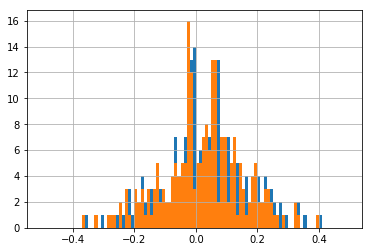

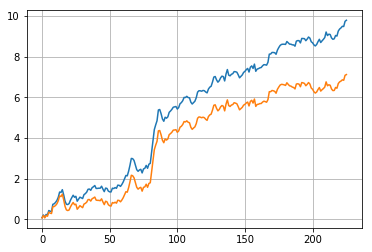

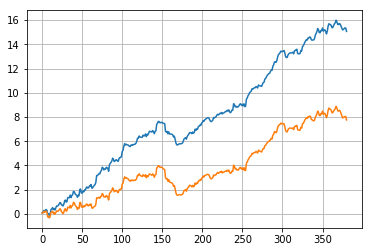

In [155]:
import matplotlib.pyplot as plt

plt.figure(0)
bins = [i/100 for i in range(-50,50)]
histG = plt.hist(pos_under_thr['GROI'], bins=bins)
histR = plt.hist(pos_under_thr['ROI'], bins=bins)
plt.grid()

#pos_under_thr.index = range(pos_under_thr.shape[0])
plt.figure(1)
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['GROI'].cumsum())
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['ROI'].cumsum())
plt.grid()

plt.figure(2)
#print(pos_under_thr['ROI'])
print(positions[pos_under_2p]['GROI'].shape)
cumG = plt.plot(positions['GROI'].cumsum())#, bins=bins
cumR = plt.plot(positions['ROI'].cumsum())
plt.grid()

Asset
AUDCAD    0.3838
AUDJPY    0.2164
CHFJPY   -0.0781
EURAUD    0.4257
EURCAD    0.6322
EURCHF    0.1394
EURGBP    0.1180
EURJPY    0.6510
EURNZD    0.6333
EURUSD    1.4762
GBPAUD    0.8568
GBPCAD    0.6109
GBPCHF   -0.0293
GBPJPY    0.2895
GBPUSD    0.0766
GOLD      0.7327
NZDUSD   -0.2158
USDCAD    0.4003
USDCHF   -0.0269
USDJPY   -0.1778
Name: ROI, dtype: float64
Di
10    0.0786
11    0.1192
12    0.5745
13    0.3900
14    0.0812
16   -0.5994
17   -0.1764
18    0.3678
19   -0.0826
20   -0.1688
21    0.1724
22    0.3120
23    0.7027
24    2.1845
25    0.5724
26    1.1026
27    0.0290
28   -0.0167
31    0.0903
32   -0.0496
33   -0.2412
34    0.0630
35    0.2933
36   -0.0357
37    0.1212
38    0.5073
39    0.2365
40    0.0215
41    0.0309
42   -0.2992
43    0.0278
44    0.4496
45    0.2562
Name: ROI, dtype: float64


(array([17.,  7.,  5.,  3.,  0.]),
 array([ 0,  5, 10, 15, 20, 25]),
 <a list of 5 Patch objects>)

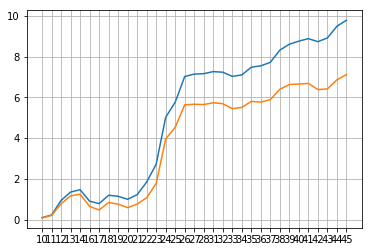

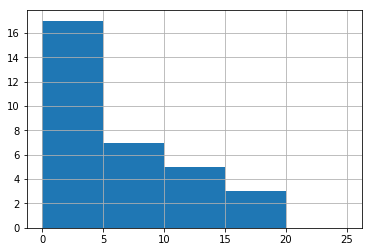

In [160]:
#positions
#grouped = pos_format.groupby(['asset'])
weekly_group = pos_under_thr.groupby([pd.to_datetime(pos_under_thr['Di']).dt.strftime('%W')])['ROI']
weekly_group_G = pos_under_thr.groupby([pd.to_datetime(pos_under_thr['Di']).dt.strftime('%W')])['GROI']
asset_group = pos_under_thr.groupby(['Asset'])
weekly_sum = weekly_group.sum()
weekly_sum_G = weekly_group_G.sum()
weekly_count = weekly_group.count()
#weekly_sum.cumsum()
#print(asset_group['GROI'].sum())
print(asset_group['ROI'].sum())
plt.figure(0)
plt.plot(weekly_sum_G.cumsum())
plt.plot(weekly_sum.cumsum())
plt.grid()
print(weekly_sum)#.cumsum()
#print(pos_under_thr.groupby([pd.to_datetime(pos_under_thr['Di']).dt.strftime('%W')])['GROI'].sum())
#print(weekly_count)
plt.figure(1)
plt.grid()
plt.hist(weekly_count, bins=range(0,max(weekly_count),5))

#for name, group in asset_group:
#    print(name)
#    print(group.to_string())
#pd.to_datetime(positions['Di']).dt.strftime('%W')
#pd.to_datetime(positions['Di'])#.groupby('Name').resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')

In [132]:
positions[positions['ROI']<-.2]['ROI'].sum()

-25.2909

In [91]:
positions['GROI'].min()

-0.5216

0.035496947809999325


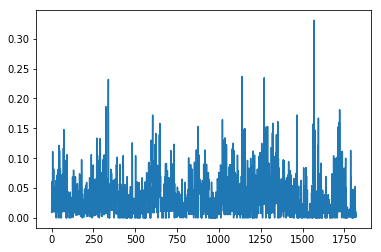

In [144]:
abs_B = (positions['Bo']-positions['Ao'])
abs_A = (positions['Bi']-positions['Ai'])
dif = 100*abs(abs_A-abs_B)/positions['Ai']
print(np.mean(dif))
plt.plot(dif)